**설정 & 경로**

In [1]:
import os, glob, json, math, random
import numpy as np
from collections import defaultdict

# ★ 사용자 설정
PROJECT_TAG   = "v1"   # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()         # 노트북 위치 기준 (원하면 바꿔도 됨)
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN            = 45   # 3초 창 (추천)
STRIDE             = 15   # 1초 간격 (66% overlap, 안정적)
MIN_ACTIVE_RATIO   = 0.20 # 창 내에서 '손이 검출된 프레임' 비율 하한 (0.0~1.0)
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)


**매니페스트 생성 (길이/차원 확인)**

In [2]:
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir): 
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir): 
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            T, F = (arr.shape[0], arr.shape[1]) if arr.ndim==2 else (0,0)
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

len(manifest), manifest[:2]


(656,
 [{'label': '왼쪽-협측',
   'y': 0,
   'person': 'P01',
   'path': 'd:\\Final_Team3\\v1\\data_v1\\왼쪽-협측\\P01\\1755673634.npy',
   'T': 150,
   'F': 48},
  {'label': '왼쪽-협측',
   'y': 0,
   'person': 'P01',
   'path': 'd:\\Final_Team3\\v1\\data_v1\\왼쪽-협측\\P01\\1755674027.npy',
   'T': 150,
   'F': 48}])

**길이 분포/차원 체크 & 경고**

In [3]:
from statistics import mean

feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)


Feature dims found: [48]
Clips: 656, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 48


**윈도잉 함수 + 활성 프레임 비율 계산**

In [4]:
def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F)
    반환: [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    # 끝이 애매하면 마지막 창 하나 더 (중복 방지)
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (seq_len, F)
    손 좌표(앞 hand_dims)를 frame별로 검사하여
    non-zero 프레임 비율을 반환.
    """
    H = hand_dims
    hand = win[:, :H]              # (L, 42)
    # 프레임별 norm (21점×2를 묶어서 한 프레임 에너지로)
    fr = hand.reshape(win.shape[0], -1)
    nz = (np.abs(fr).sum(axis=1) > eps)  # 각 프레임에 손 검출 여부
    return nz.mean()


**데이터 생성 (윈도잉 + 품질필터)**

In [5]:
X, y, meta = [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    # 윈도 생성
    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue
    # 활성 프레임 비율 필터
    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)
            y.append(m["y"])
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)  # (N, SEQ_LEN, FEAT_DIM)
y = np.array(y)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "y shape:", y.shape)


Windows kept: 5248, dropped_short: 0, dropped_inactive: 0
X shape: (5248, 45, 48) y shape: (5248,)


**사람 단위 분리(누수 방지) Train/Val 및 스케일링**

In [6]:
# === LOSO 분할 + 스케일링 (모델 학습 없이) ===
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
import numpy as np

# 윈도우별 사람 ID
persons = np.array([m["person"] for m in meta])  # 길이 N (X, y와 동일한 첫 축)

F = X.shape[-1]
# 손 좌표가 앞 42차원(21점 x,y)일 때 fit 마스킹에 사용
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7

logo = LeaveOneGroupOut()
fold_no = 0

# 필요하면 결과를 모으고 싶을 때 사용 (메모리 고려해서 주석 유지 가능)
# all_folds = []

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1

    # Split
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    persons_train, persons_val = persons[train_idx], persons[val_idx]

    # --- 스케일러: train으로만 fit ---
    scaler = StandardScaler(with_mean=True, with_std=True)

    Xtr_flat = X_train.reshape(-1, F)
    # 손이 아예 미검출(제로필)인 프레임은 fit에서 제외해 통계 왜곡 방지 (옵션)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    if mask.any():
        scaler.fit(Xtr_flat[mask])
    else:
        # 드물지만 전부 제로인 경우를 대비한 fallback
        scaler.fit(Xtr_flat)

    # transform
    X_train_s = scaler.transform(Xtr_flat).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

    print(f"[LOSO Fold {fold_no}] "
          f"Train {X_train_s.shape}, Val {X_val_s.shape} | "
          f"persons train={len(set(persons_train))}, val={len(set(persons_val))}")

[LOSO Fold 1] Train (4728, 45, 48), Val (520, 45, 48) | persons train=21, val=1
[LOSO Fold 2] Train (4728, 45, 48), Val (520, 45, 48) | persons train=21, val=1
[LOSO Fold 3] Train (4936, 45, 48), Val (312, 45, 48) | persons train=21, val=1
[LOSO Fold 4] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 5] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 6] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 7] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 8] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 9] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 10] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 11] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 12] Train (5048, 45, 48), Val (200, 45, 48) | persons train=21, val=1
[LOSO Fold 13] Train (5072, 45, 48), 

In [7]:
import tensorflow as tf, gc, os
# (선택) GPU 메모리 점진 할당
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("set_memory_growth 실패:", e)


**3클래스 매핑(오른쪽, 중앙, 왼쪽) + 모델 빌더**

In [134]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

def build_gru_model(input_shape, n_classes=3):
    inp = layers.Input(shape=input_shape)               # (SEQ_LEN, 48)

    # 규제: 입력 노이즈 + 채널 드롭
    x = layers.GaussianNoise(0.01)(inp)
    x = layers.SpatialDropout1D(0.2)(x)

    # GRU (recurrent_dropout=0.0로 안정화)
    x = layers.GRU(
        96, return_sequences=True,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.GRU(
        64,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4)
    )(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(n_classes, activation="softmax")(x)
    model = tf.keras.Model(inp, out)

    # 안정 우선: Adam
    opt  = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)

    # 안정 우선: 표준 sparse CE (스무딩 잠시 off)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model

# === 멀티태스크 모델 요약 출력 ===
tmp = build_gru_model(input_shape=(SEQ_LEN, FEAT_DIM))
tmp.summary(line_length=120, expand_nested=False, show_trainable=True)


Model: "model_2"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 input_2 (InputLayer)                                 [(None, 30, 48)]                                0                 Y          
                                                                                                                                   
 gaussian_noise (GaussianNoise)                       (None, 30, 48)                                  0                 Y          
                                                                                                                                   
 spatial_dropout1d (SpatialDropout1D)                 (None, 30, 48)                                  0                 Y          
                                                           

In [9]:
# 한글 폰트 설정 + 마이너스 기호
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False

setup_korean_font()
print("Matplotlib font.family =", plt.rcParams["font.family"])


Matplotlib font.family = ['Malgun Gothic']


**LOSO + 스케일링 + 학습/평가(윈도/클립)**

Epoch 1/80
74/74 [==============================] - 3s 12ms/step - loss: 1.2753 - accuracy: 0.5315 - val_loss: 0.8639 - val_accuracy: 0.6846 - lr: 3.0000e-04
Epoch 2/80
74/74 [==============================] - 1s 8ms/step - loss: 0.9199 - accuracy: 0.6758 - val_loss: 0.7235 - val_accuracy: 0.6962 - lr: 3.0000e-04
Epoch 3/80
74/74 [==============================] - 1s 8ms/step - loss: 0.7950 - accuracy: 0.7308 - val_loss: 0.6511 - val_accuracy: 0.7385 - lr: 3.0000e-04
Epoch 4/80
74/74 [==============================] - 1s 8ms/step - loss: 0.7089 - accuracy: 0.7606 - val_loss: 0.5195 - val_accuracy: 0.7827 - lr: 3.0000e-04
Epoch 5/80
74/74 [==============================] - 1s 8ms/step - loss: 0.6549 - accuracy: 0.7779 - val_loss: 0.4089 - val_accuracy: 0.8192 - lr: 3.0000e-04
Epoch 6/80
74/74 [==============================] - 1s 8ms/step - loss: 0.5980 - accuracy: 0.8031 - val_loss: 0.4152 - val_accuracy: 0.8385 - lr: 3.0000e-04
Epoch 7/80
74/74 [==============================] - 1s 8m

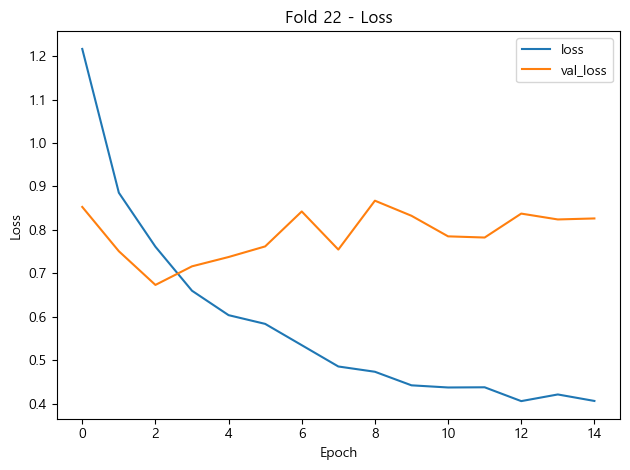

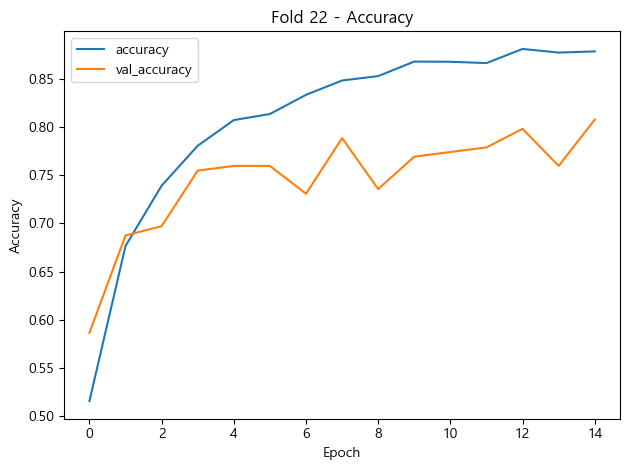


==== LOSO Summary (fold-wise) ====
Mean Window Acc: 0.849 ± 0.095
Mean Clip   Acc: 0.861 ± 0.099

==== OVERALL (클립) ====
Overall 클립 Acc: 0.872
              precision    recall  f1-score   support

          왼쪽      0.857     0.867     0.862       255
          중앙      0.937     0.893     0.915       150
         오른쪽      0.851     0.865     0.858       251

    accuracy                          0.872       656
   macro avg      0.882     0.875     0.878       656
weighted avg      0.873     0.872     0.872       656



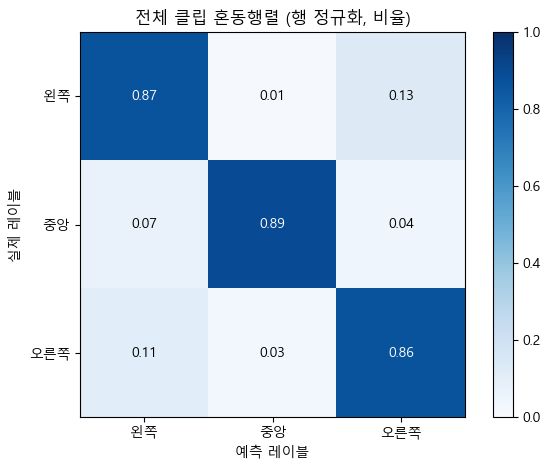

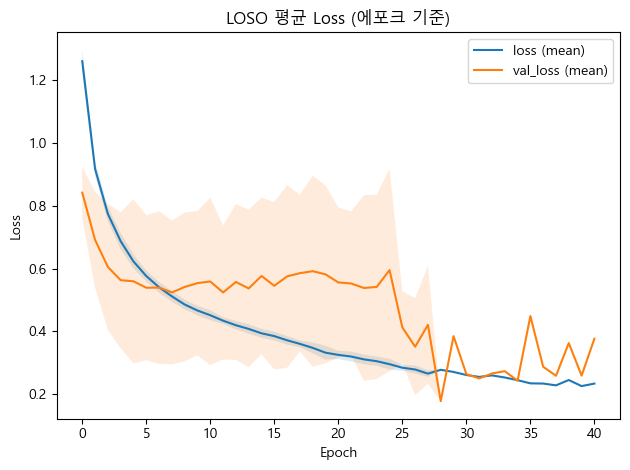

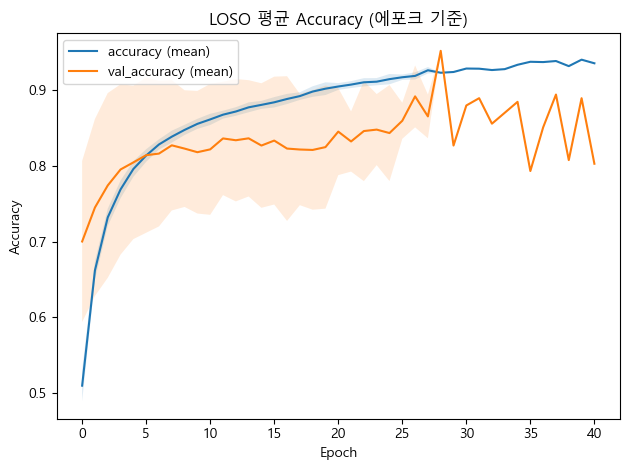

In [11]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import font_manager

# ===== 옵션 =====
EPOCHS = 80
BATCH_SIZE = 64
ES_PATIENCE = 12
RLR_PATIENCE = 6

# 마지막 폴드에서만 에포크 곡선 출력 (그래프 폭주 방지)
PLOT_LAST_FOLD_CURVES = True

# 최종 혼동행렬/지표를 어느 레벨로 볼지 선택: "clip" 또는 "window"
EVAL_LEVEL = "clip"   # ← 필요하면 "window"로 변경

# 한글 폰트 (깨짐 방지)
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

F = X.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7
logo = LeaveOneGroupOut()
persons = np.array([m["person"] for m in meta])

CLASS_NAMES = ['왼쪽','중앙','오른쪽']

# ---------- 학습 곡선(폴드별) ----------
def plot_training_curves(history, fold_no):
    H = history.history
    # Loss & Val Loss 한 플롯
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy & Val Accuracy 한 플롯 (metrics에 accuracy가 있을 때만)
    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ---------- 혼동행렬(비율) ----------
def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    """행 정규화(비율) 혼동행렬 + 셀 내 값 표기, 밝은 컬러맵"""
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)  # 밝은 톤
    plt.title(title)
    plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)
    # 셀 안 값 표시 + 배경 대비 텍스트 색상 자동 조절
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'  # 밝은 배경엔 검정, 진하면 흰색
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블')
    plt.xlabel('예측 레이블')
    plt.tight_layout()
    plt.show()

# ---------- 13→3 매핑 ----------
labels_np = np.array(KOREAN_LABELS, dtype=object)
lab_to_group = {l: ('왼쪽' if l.startswith('왼쪽') else '중앙' if l.startswith('중앙') else '오른쪽') for l in labels_np}
group_to_idx = {'왼쪽':0, '중앙':1, '오른쪽':2}
def map_y_to_3(y13):
    return np.array([group_to_idx[lab_to_group[labels_np[i]]] for i in y13])

# ---------- 폴드 평균 곡선 유틸 ----------
def _nanmean_along_epochs(list_of_lists):
    """
    길이가 다른 에포크 시퀀스를 뒤쪽 NaN으로 패딩하고, 에포크축으로 nanmean/nanstd을 구함.
    """
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    """
    LOSO 전체 폴드의 에포크별 곡선을 평균해 한 플롯에 그림.
    - Loss/Val Loss 한 장 (+표준편차 음영)
    - Accuracy/Val Accuracy 한 장 (+표준편차 음영, metrics 있을 때)
    """
    # Loss
    mean_loss, std_loss         = _nanmean_along_epochs([h['loss'] for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h['val_loss'] for h in histories])

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss, mean_loss + std_loss, alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc             = _nanmean_along_epochs([h['accuracy'] for h in histories])
        mean_val_acc, std_val_acc     = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc, mean_acc + std_acc, alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ========= 학습/검증 루프 =========
# (추가) 폴드별 history 저장 버퍼
histories = []

# 전체(모든 폴드) 집계 버퍼
all_win_true, all_win_pred = [], []
all_clip_true, all_clip_pred = [], []

fold_no = 0
all_win_acc, all_clip_acc = [], []
total_folds = len(np.unique(persons))

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1

    # --- Split ---
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    y_train_3 = map_y_to_3(y_train)
    y_val_3   = map_y_to_3(y_val)

    # --- 스케일러: train으로만 fit ---
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    X_train_s = scaler.transform(Xtr_flat).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

    # --- 모델 구성/학습 ---
    # 주의: build_gru_model 안에서 model.compile(..., metrics=['accuracy']) 포함되어 있어야 accuracy 그래프가 보입니다.
    model = build_gru_model(input_shape=(X_train_s.shape[1], X_train_s.shape[2]), n_classes=3)

    cls_counts = np.bincount(y_train_3, minlength=3)
    class_weights = {i: float(np.median(cls_counts)/c) for i,c in enumerate(cls_counts)}

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
    ]

    # 에포크 진행상황 콘솔 출력(verbose=1)
    history = model.fit(
        X_train_s, y_train_3,
        validation_data=(X_val_s, y_val_3),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=cb, verbose=1
    )

    # (추가) 폴드 history 저장 → 나중에 평균 곡선 그릴 때 사용
    histories.append(history.history)

    # (옵션) 마지막 폴드에서만 폴드별 곡선 표시
    if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
        plot_training_curves(history, fold_no)

    # --- 윈도우 단위 예측/평가 ---
    p3 = model.predict(X_val_s, verbose=0)           # (N_val, 3)
    y_pred = p3.argmax(1)
    win_acc = accuracy_score(y_val_3, y_pred)
    all_win_acc.append(win_acc)
    all_win_true.append(y_val_3)
    all_win_pred.append(y_pred)

    # --- 클립 단위 집계 ---
    bucket_p, bucket_y = defaultdict(list), {}
    val_meta = [meta[i] for i in val_idx]
    for i, m in enumerate(val_meta):
        bucket_p[m["src"]].append(p3[i])
        bucket_y[m["src"]] = y_val_3[i]
    P_clip, Y_clip = [], []
    for src, ps in bucket_p.items():
        P_clip.append(np.mean(ps, axis=0))
        Y_clip.append(bucket_y[src])
    clip_pred = np.argmax(np.vstack(P_clip), axis=1)
    clip_acc = accuracy_score(Y_clip, clip_pred)
    all_clip_acc.append(clip_acc)
    all_clip_true.append(np.array(Y_clip))
    all_clip_pred.append(clip_pred)

# ===== 폴드 전체 집계 =====
all_win_true  = np.concatenate(all_win_true, axis=0)
all_win_pred  = np.concatenate(all_win_pred, axis=0)
all_clip_true = np.concatenate(all_clip_true, axis=0)
all_clip_pred = np.concatenate(all_clip_pred, axis=0)

print("\n==== LOSO Summary (fold-wise) ====")
print(f"Mean Window Acc: {np.mean(all_win_acc):.3f} ± {np.std(all_win_acc):.3f}")
print(f"Mean Clip   Acc: {np.mean(all_clip_acc):.3f} ± {np.std(all_clip_acc):.3f}")

# ===== 최종(전체 사람) 혼동행렬/지표: 레벨 선택 =====
if EVAL_LEVEL == "clip":
    y_true_overall = all_clip_true
    y_pred_overall = all_clip_pred
    level_name = "클립"
else:
    y_true_overall = all_win_true
    y_pred_overall = all_win_pred
    level_name = "윈도우"

overall_acc = accuracy_score(y_true_overall, y_pred_overall)
print(f"\n==== OVERALL ({level_name}) ====")
print(f"Overall {level_name} Acc: {overall_acc:.3f}")
print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

# ==== 최종 혼동행렬 (비율만, 밝은 컬러, 셀 값 표시) ====
cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1,2])
plot_confmat_ratio(cm_overall, CLASS_NAMES, f'전체 {level_name} 혼동행렬 (행 정규화, 비율)')

# ==== (NEW) LOSO 평균 곡선 플로팅 ====
plot_mean_training_curves(histories)


**Epoch 27에서 자르기**

TF version: 2.10.0
Built with CUDA: True
GPU 인식됨: 물리 1개 / 논리 1개
GPU 이름: ['NVIDIA GeForce RTX 4070']
Epoch 1/27
74/74 [==============================] - 3s 12ms/step - loss: 1.2591 - accuracy: 0.5412 - val_loss: 0.8577 - val_accuracy: 0.6981 - lr: 3.0000e-04
Epoch 2/27
74/74 [==============================] - 1s 8ms/step - loss: 0.8973 - accuracy: 0.6732 - val_loss: 0.6874 - val_accuracy: 0.7404 - lr: 3.0000e-04
Epoch 3/27
74/74 [==============================] - 1s 8ms/step - loss: 0.7811 - accuracy: 0.7305 - val_loss: 0.5346 - val_accuracy: 0.7942 - lr: 3.0000e-04
Epoch 4/27
74/74 [==============================] - 1s 8ms/step - loss: 0.6916 - accuracy: 0.7661 - val_loss: 0.5240 - val_accuracy: 0.7904 - lr: 3.0000e-04
Epoch 5/27
74/74 [==============================] - 1s 8ms/step - loss: 0.6538 - accuracy: 0.7843 - val_loss: 0.4240 - val_accuracy: 0.8231 - lr: 3.0000e-04
Epoch 6/27
74/74 [==============================] - 1s 8ms/step - loss: 0.5943 - accuracy: 0.8041 - val_loss: 0.42

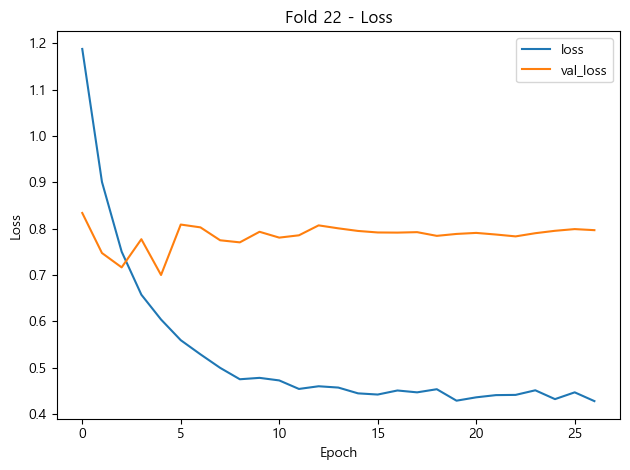

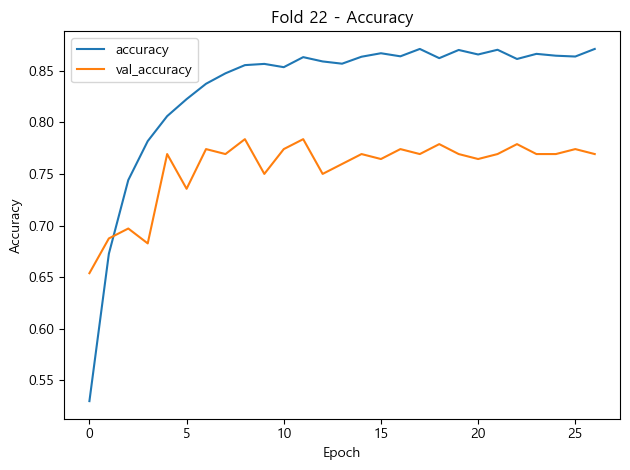


==== LOSO Summary (fold-wise) ====
Mean Window Acc: 0.830 ± 0.111
Mean Clip   Acc: 0.835 ± 0.118

==== OVERALL (클립) ====
Overall 클립 Acc: 0.849
              precision    recall  f1-score   support

          왼쪽      0.852     0.835     0.844       255
          중앙      0.863     0.880     0.871       150
         오른쪽      0.838     0.845     0.841       251

    accuracy                          0.849       656
   macro avg      0.851     0.853     0.852       656
weighted avg      0.849     0.849     0.849       656



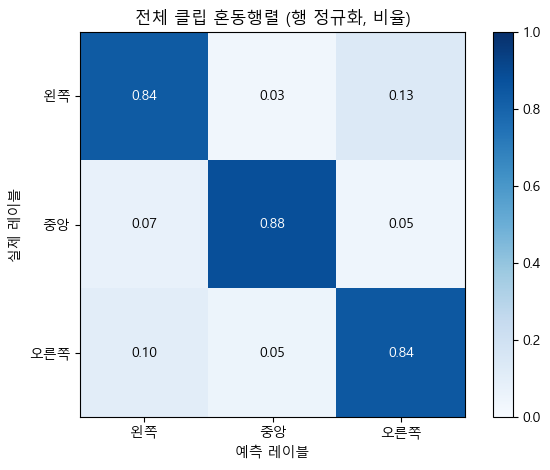

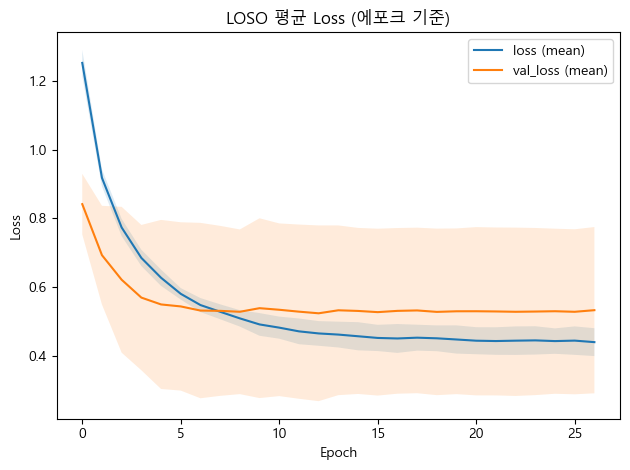

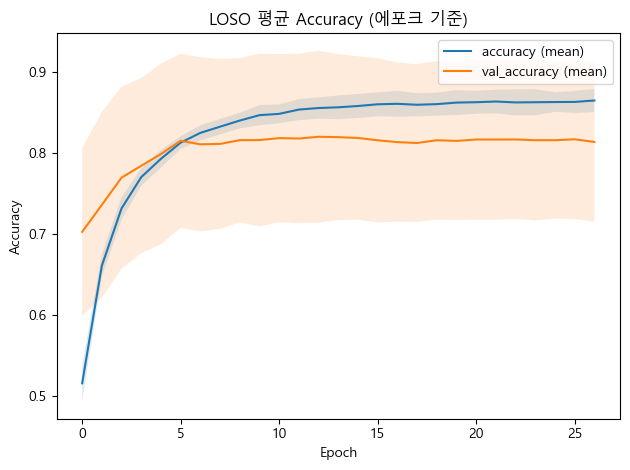

In [10]:
# === LOSO 학습/평가 (EPOCHS=27 고정 + 최적 가중치 체크포인트 복원) ===
# * 사전 준비: X, y, meta, KOREAN_LABELS, build_gru_model() 이 앞 셀에서 정의되어 있어야 합니다.

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from collections import defaultdict

import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ===== 옵션 =====
EPOCHS = 27            # <-- 고정 에포크
BATCH_SIZE = 64
RLR_PATIENCE = 2       # 27ep 안에서 한두 번 LR 감소 유도
PLOT_LAST_FOLD_CURVES = True
EVAL_LEVEL = "clip"    # "clip" 또는 "window"

# ===== 한글 폰트 (깨짐 방지) =====
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

F = X.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7
logo = LeaveOneGroupOut()
persons = np.array([m["person"] for m in meta])

CLASS_NAMES = ['왼쪽','중앙','오른쪽']

# ---------- 학습 곡선(폴드별) ----------
def plot_training_curves(history, fold_no):
    H = history.history
    # Loss & Val Loss 한 플롯
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy & Val Accuracy 한 플롯 (metrics에 accuracy가 있을 때만)
    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ---------- 혼동행렬(비율) ----------
def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    """행 정규화(비율) 혼동행렬 + 셀 내 값 표기, 밝은 컬러맵"""
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)  # 밝은 톤
    plt.title(title)
    plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)
    # 셀 안 값 표시 + 배경 대비 텍스트 색상 자동 조절
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블')
    plt.xlabel('예측 레이블')
    plt.tight_layout()
    plt.show()

# ---------- 13→3 매핑 ----------
labels_np = np.array(KOREAN_LABELS, dtype=object)
lab_to_group = {l: ('왼쪽' if l.startswith('왼쪽') else '중앙' if l.startswith('중앙') else '오른쪽') for l in labels_np}
group_to_idx = {'왼쪽':0, '중앙':1, '오른쪽':2}
def map_y_to_3(y13):
    return np.array([group_to_idx[lab_to_group[labels_np[i]]] for i in y13])

# ---------- 폴드 평균 곡선 유틸 ----------
def _nanmean_along_epochs(list_of_lists):
    """길이가 다른 에포크 시퀀스를 뒤쪽 NaN으로 패딩하고, 에포크축으로 nanmean/nanstd 계산."""
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    """LOSO 전체 폴드의 에포크별 곡선을 평균해 한 플롯에 그림."""
    # Loss
    mean_loss, std_loss         = _nanmean_along_epochs([h['loss'] for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h['val_loss'] for h in histories])

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy'] for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

# ========= 학습/검증 루프 =========
histories = []                     # 폴드별 history 저장
all_win_true, all_win_pred = [], []
all_clip_true, all_clip_pred = [], []
fold_no = 0
all_win_acc, all_clip_acc = [], []
total_folds = len(np.unique(persons))

# ===== GPU 체크 & 세팅 =====
import tensorflow as tf

LOG_DEVICE_PLACEMENT = False  # True로 바꾸면 연산마다 디바이스(log)가 쭉 출력됨(매우 많음)

def setup_and_check_gpu():
    print("TF version:", tf.__version__)
    print("Built with CUDA:", tf.test.is_built_with_cuda())

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        # OOM 방지용 메모리 증가 허용
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print("set_memory_growth 실패:", e)

        # 디바이스 정보 출력
        names = []
        for gpu in gpus:
            try:
                info = tf.config.experimental.get_device_details(gpu)
                names.append(info.get('device_name', gpu.name))
            except:
                names.append(getattr(gpu, 'name', 'GPU'))

        logical = tf.config.list_logical_devices('GPU')
        print(f"GPU 인식됨: 물리 {len(gpus)}개 / 논리 {len(logical)}개")
        print("GPU 이름:", names)
    else:
        print("GPU 미인식 → CPU로 학습합니다.")

    if LOG_DEVICE_PLACEMENT:
        tf.debugging.set_log_device_placement(True)

setup_and_check_gpu()


for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1

    # --- Split ---
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    y_train_3 = map_y_to_3(y_train)
    y_val_3   = map_y_to_3(y_val)

    # --- 스케일러: train으로만 fit ---
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    X_train_s = scaler.transform(Xtr_flat).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

    # --- 모델 구성/학습 ---
    model = build_gru_model(input_shape=(X_train_s.shape[1], X_train_s.shape[2]), n_classes=3)

    cls_counts = np.bincount(y_train_3, minlength=3)
    class_weights = {i: float(np.median(cls_counts)/c) for i,c in enumerate(cls_counts)}

    # 폴드별 베스트 가중치 저장 경로
    best_w_path = f'_tmp_best_fold{fold_no:02d}.weights.h5'

    cb = [
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=best_w_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        ),
    ]

    history = model.fit(
        X_train_s, y_train_3,
        validation_data=(X_val_s, y_val_3),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        class_weight=class_weights,
        callbacks=cb, verbose=1
    )

    # 27 에포크 중 최적 에포크 정보 출력 + 복원
    best_epoch = int(np.argmin(history.history['val_loss']) + 1)
    best_vloss = float(np.min(history.history['val_loss']))
    print(f"[Fold {fold_no}] best_epoch(within 27) = {best_epoch}, best_val_loss = {best_vloss:.4f}")

    if os.path.exists(best_w_path):
        model.load_weights(best_w_path)
        try:
            os.remove(best_w_path)
        except OSError:
            pass

    # (옵션) 마지막 폴드에서만 폴드별 곡선 표시
    if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
        plot_training_curves(history, fold_no)

    histories.append(history.history)

    # --- 윈도우 단위 예측/평가 ---
    p3 = model.predict(X_val_s, verbose=0)           # (N_val, 3)
    y_pred = p3.argmax(1)
    win_acc = accuracy_score(y_val_3, y_pred)
    all_win_acc.append(win_acc)
    all_win_true.append(y_val_3)
    all_win_pred.append(y_pred)

    # --- 클립 단위 집계 ---
    bucket_p, bucket_y = defaultdict(list), {}
    val_meta = [meta[i] for i in val_idx]
    for i, m in enumerate(val_meta):
        bucket_p[m["src"]].append(p3[i])
        bucket_y[m["src"]] = y_val_3[i]
    P_clip, Y_clip = [], []
    for src, ps in bucket_p.items():
        P_clip.append(np.mean(ps, axis=0))
        Y_clip.append(bucket_y[src])
    clip_pred = np.argmax(np.vstack(P_clip), axis=1)
    clip_acc = accuracy_score(Y_clip, clip_pred)
    all_clip_acc.append(clip_acc)
    all_clip_true.append(np.array(Y_clip))
    all_clip_pred.append(clip_pred)

# ===== 폴드 전체 집계 =====
all_win_true  = np.concatenate(all_win_true, axis=0)
all_win_pred  = np.concatenate(all_win_pred, axis=0)
all_clip_true = np.concatenate(all_clip_true, axis=0)
all_clip_pred = np.concatenate(all_clip_pred, axis=0)

print("\n==== LOSO Summary (fold-wise) ====")
print(f"Mean Window Acc: {np.mean(all_win_acc):.3f} ± {np.std(all_win_acc):.3f}")
print(f"Mean Clip   Acc: {np.mean(all_clip_acc):.3f} ± {np.std(all_clip_acc):.3f}")

# ===== 최종(전체 사람) 혼동행렬/지표: 레벨 선택 =====
if EVAL_LEVEL == "clip":
    y_true_overall = all_clip_true
    y_pred_overall = all_clip_pred
    level_name = "클립"
else:
    y_true_overall = all_win_true
    y_pred_overall = all_win_pred
    level_name = "윈도우"

overall_acc = accuracy_score(y_true_overall, y_pred_overall)
print(f"\n==== OVERALL ({level_name}) ====")
print(f"Overall {level_name} Acc: {overall_acc:.3f}")
print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

# ==== 최종 혼동행렬 (비율만, 밝은 컬러, 셀 값 표시) ====
cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1,2])
plot_confmat_ratio(cm_overall, CLASS_NAMES, f'전체 {level_name} 혼동행렬 (행 정규화, 비율)')

# ==== LOSO 평균 곡선 플로팅 ====
plot_mean_training_curves(histories)


**배포용 모델 학습 및 저장**

In [11]:
# === 배포용 모델 학습 & 저장 ===
# 전제: X (N, SEQ_LEN, F), y (N,), meta, map_y_to_3, build_gru_model 가 이미 정의되어 있음

import os, json
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import dump

SAVE_DIR = "deploy_v1"
os.makedirs(SAVE_DIR, exist_ok=True)

SEQ_LEN   = X.shape[1]
FEAT_DIM  = X.shape[2]
HAND_DIMS = 42 if FEAT_DIM >= 42 else FEAT_DIM
EPS       = 1e-7

# 1) 전체 데이터로 스케일러 fit (train 통계만 사용하던 LOSO와 달리, 배포용은 전체로 fit)
scaler_all = StandardScaler(with_mean=True, with_std=True)
X_flat = X.reshape(-1, FEAT_DIM)
mask   = (np.abs(X_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
scaler_all.fit(X_flat[mask] if mask.any() else X_flat)

X_s = scaler_all.transform(X_flat).reshape(X.shape)
y3  = map_y_to_3(y)  # 13→3 매핑 사용

# 2) 모델 구성 & 학습 (27 epoch 고정, 내부에서 ReduceLROnPlateau 정도만)
model = build_gru_model(input_shape=(SEQ_LEN, FEAT_DIM), n_classes=3)

# 클래스 불균형 보정
cls_counts = np.bincount(y3, minlength=3)
class_weights = {i: float(np.median(cls_counts)/c) for i,c in enumerate(cls_counts)}

cb = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss',
                                     restore_best_weights=True)  # 배포용은 살짝 켜두는 걸 권장
]

history_prod = model.fit(
    X_s, y3,
    validation_split=0.1,  # 작은 검증을 둬서 과적합 감시
    epochs=27, batch_size=64,
    class_weight=class_weights,
    callbacks=cb, verbose=1
)

# 3) 아티팩트 저장
model_path  = os.path.join(SAVE_DIR, "model_3cls.keras")
scaler_path = os.path.join(SAVE_DIR, "scaler.pkl")
cfg_path    = os.path.join(SAVE_DIR, "config.json")

model.save(model_path)
dump(scaler_all, scaler_path)

with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump({
        "seq_len": SEQ_LEN,
        "feat_dim": FEAT_DIM,
        "class_names": ['왼쪽','중앙','오른쪽']
    }, f, ensure_ascii=False, indent=2)

print("Saved:", model_path, scaler_path, cfg_path)


Epoch 1/27
74/74 [==============================] - 2s 14ms/step - loss: 1.2553 - accuracy: 0.4906 - val_loss: 0.9635 - val_accuracy: 0.6971 - lr: 3.0000e-04
Epoch 2/27
74/74 [==============================] - 1s 9ms/step - loss: 0.9036 - accuracy: 0.6581 - val_loss: 0.8813 - val_accuracy: 0.7029 - lr: 3.0000e-04
Epoch 3/27
74/74 [==============================] - 1s 8ms/step - loss: 0.7492 - accuracy: 0.7313 - val_loss: 0.9384 - val_accuracy: 0.6190 - lr: 3.0000e-04
Epoch 4/27
74/74 [==============================] - 1s 8ms/step - loss: 0.6513 - accuracy: 0.7783 - val_loss: 0.8999 - val_accuracy: 0.6800 - lr: 3.0000e-04
Epoch 5/27
74/74 [==============================] - 1s 8ms/step - loss: 0.5942 - accuracy: 0.8071 - val_loss: 0.8870 - val_accuracy: 0.6971 - lr: 1.5000e-04
Epoch 6/27
74/74 [==============================] - 1s 8ms/step - loss: 0.5730 - accuracy: 0.8103 - val_loss: 0.8800 - val_accuracy: 0.6857 - lr: 1.5000e-04
Epoch 7/27
74/74 [==============================] - 1s 8m

**왼쪽/오른쪽/중앙 실시간 추론**

In [141]:
# -*- coding: utf-8 -*-
"""
Realtime inference for 3-class (왼쪽/중앙/오른쪽)
- 학습 파이프라인과 맞춘 15fps 리샘플링(프레임 평균)
- 코 원점 + 눈-눈 정렬 + 눈거리 스케일 정규화
- 손(21*2=42) + 얼굴 보조(인중/입꼬리 3점*2=6) = 48차 피처
- 화면 미러링(보기용)과 특징 좌우반전(학습 좌우 기준) 분리 토글
"""

import os, json, time
import numpy as np
import cv2
from collections import deque
from joblib import load
import tensorflow as tf
from typing import Optional

# ----------------- 경로 -----------------
SAVE_DIR = "deploy_v1"  # 배포용 저장 폴더
MODEL_PATH  = os.path.join(SAVE_DIR, "model_3cls.keras")
SCALER_PATH = os.path.join(SAVE_DIR, "scaler.pkl")
CFG_PATH    = os.path.join(SAVE_DIR, "config.json")

# ----------------- 로드 -----------------
model  = tf.keras.models.load_model(MODEL_PATH)
scaler = load(SCALER_PATH)
with open(CFG_PATH, "r", encoding="utf-8") as f:
    CFG = json.load(f)

SEQ_LEN     = int(CFG["seq_len"])     # 예: 45
FEAT_DIM    = int(CFG["feat_dim"])    # 예: 48
CLASS_NAMES = list(CFG["class_names"])

# ----------------- 하이퍼파라미터 -----------------
TARGET_FPS       = 15                 # 학습과 동일
ACTIVE_RATIO_MIN = 0.20               # 손-활성 임계(학습과 동일)
PROB_SMOOTH_WIN  = 5                  # 최근 윈도 평균 개수
TEXT_COLOR       = (0, 255, 0)
DBG_COLOR        = (0, 255, 255)

# ----------------- MediaPipe -----------------
try:
    import mediapipe as mp
except Exception as e:
    raise RuntimeError("pip install mediapipe 필요") from e

mp_face = mp.solutions.face_mesh
mp_hands = mp.solutions.hands

# FaceMesh 인덱스 (사람 기준 왼/오)
NOSE_TIP_IDX    = 1
LEFT_EYE_IDX    = 133
RIGHT_EYE_IDX   = 362
PHILTRUM_IDX    = 13
MOUTH_LEFT_IDX  = 61
MOUTH_RIGHT_IDX = 291

def rot2d(theta: float) -> np.ndarray:
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]], dtype=np.float32)

def resample_step(in_fps: float, out_fps: float = TARGET_FPS) -> int:
    if in_fps is None or in_fps <= 1: return 1
    if out_fps <= 0: return 1
    return max(1, int(round(in_fps / out_fps)))

# ----------------- Pillow 한글 출력 -----------------
from PIL import Image, ImageFont, ImageDraw

_FONT_CANDIDATES = [
    r"C:\Windows\Fonts\malgun.ttf",
    r"C:\Windows\Fonts\malgunbd.ttf",
    "/System/Library/Fonts/AppleGothic.ttf",
    "/Library/Fonts/AppleGothic.ttf",
    "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc",
    "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
]
def _pick_korean_font() -> Optional[str]:
    for p in _FONT_CANDIDATES:
        if os.path.exists(p):
            return p
    return None
_KOR_FONT = _pick_korean_font()

def draw_korean(img_bgr, text, org=(12, 36), size=28, color=(0,255,0), stroke=2):
    if _KOR_FONT is None:
        # 폰트가 없으면 영문만 그려짐
        cv2.putText(img_bgr, text, org, cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
        return img_bgr
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil_im  = Image.fromarray(img_rgb)
    draw    = ImageDraw.Draw(pil_im)
    font    = ImageFont.truetype(_KOR_FONT, size)
    x, y = org
    # 외곽선
    for dx, dy in [(-stroke,0),(stroke,0),(0,-stroke),(0,stroke)]:
        draw.text((x+dx, y+dy), text, font=font, fill=(0,0,0))
    # 본문 (BGR→RGB)
    draw.text(org, text, font=font, fill=(int(color[2]), int(color[1]), int(color[0])))
    return cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)

# ----------------- 특징 추출 -----------------
def extract_48d_feature_from_frame(
    frame_bgr,
    face_model,
    hand_model,
    flip_x_for_features: bool = False
):
    """
    입력: BGR frame
    출력: (feat(48,), hand_detected(bool)) 또는 (None, False)
    좌표계: 코 원점, 눈-눈 정렬, 눈거리 스케일
    """
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    f_res = face_model.process(rgb)
    if not f_res.multi_face_landmarks:
        return None, False

    face_lm = f_res.multi_face_landmarks[0].landmark
    le = np.array([face_lm[LEFT_EYE_IDX].x,  face_lm[LEFT_EYE_IDX].y], dtype=np.float32)
    re = np.array([face_lm[RIGHT_EYE_IDX].x, face_lm[RIGHT_EYE_IDX].y], dtype=np.float32)
    nose = np.array([face_lm[NOSE_TIP_IDX].x, face_lm[NOSE_TIP_IDX].y], dtype=np.float32)

    eye_vec = re - le
    roll = np.arctan2(float(eye_vec[1]), float(eye_vec[0]))
    R = rot2d(-roll)
    scale = float(np.linalg.norm(eye_vec) + 1e-6)

    def nrm_face(idx):
        p = np.array([face_lm[idx].x, face_lm[idx].y], dtype=np.float32) - nose
        p = (R @ p) / scale
        if flip_x_for_features: p[0] = -p[0]
        return p

    phil = nrm_face(PHILTRUM_IDX)
    mL   = nrm_face(MOUTH_LEFT_IDX)
    mR   = nrm_face(MOUTH_RIGHT_IDX)
    face_aux = np.array([phil[0], phil[1], mL[0], mL[1], mR[0], mR[1]], dtype=np.float32)

    h_res = hand_model.process(rgb)
    hand_flat = np.zeros(42, dtype=np.float32)
    hand_detected = False
    if h_res.multi_hand_landmarks:
        hand_detected = True
        pts = []
        hand = h_res.multi_hand_landmarks[0].landmark
        for i in range(21):
            p = np.array([hand[i].x, hand[i].y], dtype=np.float32) - nose
            p = (R @ p) / scale
            if flip_x_for_features: p[0] = -p[0]
            pts.extend([p[0], p[1]])
        hand_flat = np.array(pts, dtype=np.float32)

    feat = np.concatenate([hand_flat, face_aux], axis=0)
    return feat, hand_detected

# ----------------- 런타임 -----------------
def main():
    # 상태 토글
    flip_screen = True      # 화면만 미러 (보기용) : 'M' 키로 토글
    flip_x_feat = False     # 특징 좌우 반전     : 'F' 키로 토글 (학습 좌우 기준 어긋나면 True)
    show_debug  = True      # 'D' 키로 토글

    # 윈도/스무딩 버퍼
    win_buf   = deque(maxlen=SEQ_LEN)               # (48,) 시퀀스
    flag_buf  = deque(maxlen=SEQ_LEN)               # 손 검출 여부
    prob_buf  = deque(maxlen=PROB_SMOOTH_WIN)       # 소프트맥스 스무딩

    # 프레임 리샘플링(학습과 동일 15fps)
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("웹캠을 열 수 없습니다.")
        return

    cam_fps = cap.get(cv2.CAP_PROP_FPS)
    step = resample_step(cam_fps, TARGET_FPS)  # ex) 30fps 카메라면 step=2
    raw_feat_group = []     # step개 모아서 평균 → 1개 타임스텝
    raw_flag_group = []

    # MediaPipe
    face_model = mp_face.FaceMesh(
        static_image_mode=False, max_num_faces=1, refine_landmarks=True,
        min_detection_confidence=0.5, min_tracking_confidence=0.5
    )
    hand_model = mp_hands.Hands(
        static_image_mode=False, max_num_hands=1,
        min_detection_confidence=0.4, min_tracking_confidence=0.4
    )

    last_label = "대기중"
    last_probs = np.array([0.0, 0.0, 0.0], dtype=np.float32)

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        # 보기용 화면 미러
        disp = cv2.flip(frame, 1) if flip_screen else frame.copy()

        # 특징은 원본 프레임에서 추출 (flip_x_feat로 좌우 기준만 제어)
        feat, hand_ok = extract_48d_feature_from_frame(
            frame, face_model, hand_model, flip_x_for_features=flip_x_feat
        )

        # === step 프레임 평균 → 15fps 시계열 1샘플 생성 ===
        if feat is not None and feat.shape == (FEAT_DIM,):
            raw_feat_group.append(feat)
            raw_flag_group.append(bool(hand_ok))

            if len(raw_feat_group) >= step:
                avg_feat = np.mean(np.vstack(raw_feat_group), axis=0).astype(np.float32)
                hand_flag = (np.mean(raw_flag_group) > 0.5)
                win_buf.append(avg_feat)
                flag_buf.append(hand_flag)
                raw_feat_group.clear()
                raw_flag_group.clear()

        # === 예측 (윈도 가득 찼을 때만) ===
        pred_text = last_label
        probs_to_show = last_probs

        if len(win_buf) == SEQ_LEN:
            active_ratio = float(np.mean(flag_buf))

            if active_ratio >= ACTIVE_RATIO_MIN:
                x = np.array(win_buf, dtype=np.float32).reshape(1, SEQ_LEN, FEAT_DIM)
                x_s = scaler.transform(x.reshape(-1, FEAT_DIM)).reshape(1, SEQ_LEN, FEAT_DIM)

                p = model.predict(x_s, verbose=0)[0]  # (3,)
                prob_buf.append(p)
                p_s = np.mean(np.vstack(prob_buf), axis=0).astype(np.float32)

                idx = int(np.argmax(p_s))
                last_label = CLASS_NAMES[idx]
                last_probs = p_s
                pred_text  = last_label
                probs_to_show = p_s
            else:
                pred_text = "손 없음 / 유지"

            # 디버그(윈도 내 손 x평균; zero 제외)
            if show_debug:
                arr = np.array(win_buf, dtype=np.float32)  # (L,48)
                hand = arr[:, :42].reshape(SEQ_LEN, 21, 2)
                mask = np.any(np.abs(hand) > 1e-7, axis=2)
                xs = hand[..., 0][mask]
                mean_x = float(np.mean(xs)) if xs.size else 0.0
                dbg = f"act={active_ratio:.2f}  mean_x={mean_x:+.3f}  flipX={flip_x_feat}  step={step}"
                disp = draw_korean(disp, dbg, (12, 72), size=24, color=DBG_COLOR)

        # === 한글 결과 출력 ===
        try:
            text = f"{pred_text}  [{probs_to_show[0]:.3f} {probs_to_show[1]:.3f} {probs_to_show[2]:.3f}]"
        except Exception:
            text = pred_text
        disp = draw_korean(disp, text, (12, 36), size=28, color=TEXT_COLOR)

        cv2.imshow("Realtime 3-class", disp)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:   # ESC
            break
        elif key in (ord('f'), ord('F')):
            flip_x_feat = not flip_x_feat   # 좌우 기준 토글(학습 좌/우 뒤집혔다 싶으면 켜기)
        elif key in (ord('d'), ord('D')):
            show_debug = not show_debug
        elif key in (ord('m'), ord('M')):
            flip_screen = not flip_screen   # 화면 미러 토글(보기용)

    cap.release()
    cv2.destroyAllWindows()
    face_model.close()
    hand_model.close()

if __name__ == "__main__":
    main()


**멀티태스크 두 가지 헤드 합치기(h1-왼쪽/중앙/오른쪽, h2-위/아래) + 전처리 수정**

In [132]:
# === 기본 설정 & 임포트 ===
import os, glob, json, math, random, gc
import numpy as np
from collections import defaultdict
from statistics import mean

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ★ 사용자 설정
PROJECT_TAG   = "v3"                  # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()           # 노트북 위치 기준
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일; 13-class)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN = 30      # 2초 창 (15fps * 2s)
STRIDE  = 3       # 약 0.2초 간격 (15fps에서 3프레임)
MIN_ACTIVE_RATIO   = 0.20 # 창 내 손-검출 프레임 비율 하한
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# === 윈도잉 & 마스크 유틸 ===
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)
    return (e > eps).astype(np.float32)[:, None]

def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F) -> [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    손 좌표(앞 hand_dims)를 프레임별로 검사하여 non-zero 프레임 비율 반환
    """
    H = min(hand_dims, win.shape[1])
    fr = win[:, :H]
    nz = (np.abs(fr).sum(axis=1) > eps)
    return nz.mean()

# === 매니페스트 스캔 ===
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir):
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir):
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            if arr.ndim != 2:
                print(f"[warn] skip non-2D: {npy}, shape={arr.shape}")
                continue
            T, F = arr.shape
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

print("총 manifest:", len(manifest))
if len(manifest) == 0:
    raise RuntimeError("manifest가 비었습니다. 데이터 경로/구조를 확인하세요.")

# === 데이터 전역 통계 ===
feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)

# === 윈도 생성 및 필터링 ===
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    if arr.ndim != 2 or arr.shape[1] != FEAT_DIM:
        print(f"[warn] Skip due to wrong dim: {m['path']}, shape={arr.shape}")
        continue

    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue

    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                             # (L, F)
            M.append(frame_active_mask(w))          # (L, 1)  - 현재 학습엔 미사용(옵션)
            y.append(m["y"])                        # 13-class
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)  # (옵션) 현재 미사용
y = np.array(y)           # (N,)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)

# === 13→3 매핑 ===
labels_np = np.array(KOREAN_LABELS, dtype=object)
lab_to_group = {l: ('왼쪽' if l.startswith('왼쪽') else '중앙' if l.startswith('중앙') else '오른쪽') for l in labels_np}
group_to_idx = {'왼쪽':0, '중앙':1, '오른쪽':2}
CLASS_NAMES  = ['왼쪽','중앙','오른쪽']

def map_y_to_3(y13):
    return np.array([group_to_idx[lab_to_group[labels_np[i]]] for i in y13])

# 미리 3클래스 타깃 전체 계산(폴드 내 인덱싱만 수행)
y3_all = map_y_to_3(y)

# === 스케일러 fit 유틸 (활성 프레임만) ===
from sklearn.preprocessing import StandardScaler
def fit_scaler_on_active(X_train, F, hand_dims=42, eps=1e-7):
    Xtr_flat = X_train.reshape(-1, F)
    H = min(hand_dims, F)
    mask = (np.abs(Xtr_flat[:, :H]).sum(axis=1) > eps)
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    return scaler

# === 플롯 유틸 ===
import matplotlib.pyplot as plt
from matplotlib import font_manager

def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure(); plt.plot(H.get('loss', []),     label='loss'); plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure(); plt.plot(H['accuracy'], label='accuracy'); plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    mean_loss, std_loss         = _nanmean_along_epochs([h['loss'] for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h['val_loss'] for h in histories])
    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy'] for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


총 manifest: 654
Feature dims found: [48]
Clips: 654, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 48
Windows kept: 26808, dropped_short: 0, dropped_inactive: 0
X shape: (26808, 30, 48) M shape: (26808, 30, 1) y shape: (26808,)


**태스크 라벨(왼쪽/오른쪽/중앙(pos),위/아래(ud))생성**

In [ ]:
# === 13→태스크 라벨 매핑 (pos=왼/중/오, ud=아래/위/NA) ===
import numpy as np

POS_NAMES = ['왼쪽','중앙','오른쪽']   # head #1
UD_NAMES  = ['아래','위']            # head #2 (씹는면만 유효, 나머지는 NA)

labels_np = np.array(KOREAN_LABELS, dtype=object)

def _pos_from_label(lab: str) -> int:
    if lab.startswith('왼쪽'):   return 0
    if lab.startswith('중앙'):   return 1
    if lab.startswith('오른쪽'): return 2
    raise ValueError(f"Unexpected label for pos: {lab}")

def _ud_from_label(lab: str) -> int:
    # 씹는면
    if '씹는면' in lab:
        return 1 if '위' in lab else 0
    # 구개측은 위쪽
    if '구개측' in lab:
        return 1
    # 설측은 아래쪽
    if '설측' in lab:
        return 0
    # 협측은 NA
    return -1

# 전체 샘플에 대해 태스크 라벨 생성
y_pos_all = np.array([_pos_from_label(labels_np[i]) for i in y], dtype=np.int64)
y_ud_all  = np.array([_ud_from_label(labels_np[i])  for i in y], dtype=np.int64)

# ud 유효/무효 마스크 (1:유효, 0:무효)
ud_valid_mask_all = (y_ud_all != -1).astype(np.float32)

# Keras는 -1 라벨 불가 → 더미 0으로 대체하고, 손실은 sample_weight로 마스킹
y_ud_all_clipped = np.where(y_ud_all == -1, 0, y_ud_all)


**GPU 설정**

In [119]:
# === GPU 메모리 점진 할당 & 체크(단일) ===
import tensorflow as tf

def setup_and_check_gpu():
    print("TF version:", tf.__version__)
    print("Built with CUDA:", tf.test.is_built_with_cuda())

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print("set_memory_growth 실패:", e)
        logical = tf.config.list_logical_devices('GPU')
        names = []
        for gpu in gpus:
            try:
                info = tf.config.experimental.get_device_details(gpu)
                names.append(info.get('device_name', gpu.name))
            except:
                names.append(getattr(gpu, 'name', 'GPU'))
        print(f"GPU 인식됨: 물리 {len(gpus)}개 / 논리 {len(logical)}개")
        print("GPU 이름:", names)
    else:
        print("GPU 미인식 → CPU로 학습합니다.")

setup_and_check_gpu()

# TensorFlow seed 고정
tf.random.set_seed(SEED)


TF version: 2.10.0
Built with CUDA: True
GPU 인식됨: 물리 1개 / 논리 1개
GPU 이름: ['NVIDIA GeForce RTX 4070']


**멀티 태스크 모델 빌더**

In [121]:
# === 멀티태스크 모델 빌더 (공유 인코더 + pos/ud 두 헤드) ===
from tensorflow.keras import layers, regularizers
import tensorflow as tf

def build_multitask_model(input_shape):
    """
    공유 인코더 + pos(3), ud(2) 두 헤드
    """
    inp = layers.Input(shape=input_shape, name='inp')

    # --- 공유 인코더 (기존 단일태스크와 동일 설정) ---
    x = layers.GaussianNoise(0.01, name='enc_noise')(inp)
    x = layers.SpatialDropout1D(0.2, name='enc_sdrop')(x)

    x = layers.GRU(
        96, return_sequences=True, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru1'
    )(x)
    x = layers.GRU(
        64, return_sequences=False, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru2'
    )(x)

    x = layers.BatchNormalization(name='enc_bn')(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name='enc_fc')(x)
    x = layers.Dropout(0.5, name='enc_drop')(x)

    # --- Head #1: pos(왼/중/오) ---
    pos_out = layers.Dense(3, activation='softmax', name='pos')(x)

    # --- Head #2: ud(아래/위) ---
    ud_out  = layers.Dense(2, activation='softmax', name='ud')(x)

    model = tf.keras.Model(inp, [pos_out, ud_out])

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss={'pos': tf.keras.losses.SparseCategoricalCrossentropy(),
              'ud':  tf.keras.losses.SparseCategoricalCrossentropy()},
        metrics={'pos': ['accuracy'], 'ud': ['accuracy']},
        loss_weights={'pos': 1.0, 'ud': 1.0}
    )
    return model


# === 멀티태스크 모델 요약 출력 ===
tmp = build_multitask_model(input_shape=(SEQ_LEN, FEAT_DIM))
tmp.summary(line_length=120, expand_nested=False, show_trainable=True)


Model: "model_2"
___________________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            Trainable  
 inp (InputLayer)                      [(None, 30, 48)]           0             []                                      Y          
                                                                                                                                   
 enc_noise (GaussianNoise)             (None, 30, 48)             0             ['inp[0][0]']                           Y          
                                                                                                                                   
 enc_sdrop (SpatialDropout1D)          (None, 30, 48)             0             ['enc_noise[0][0]']                     Y          
                                                           

Epoch 1/27
378/378 [==============================] - 5s 10ms/step - loss: 1.0509 - pos_loss: 0.8330 - ud_loss: 0.1749 - pos_accuracy: 0.6783 - ud_accuracy: 0.6608 - val_loss: 0.5417 - val_pos_loss: 0.3483 - val_ud_loss: 0.1504 - val_pos_accuracy: 0.8897 - val_ud_accuracy: 0.7077 - lr: 3.0000e-04
Epoch 2/27
378/378 [==============================] - 3s 9ms/step - loss: 0.6915 - pos_loss: 0.5215 - ud_loss: 0.1269 - pos_accuracy: 0.8168 - ud_accuracy: 0.6790 - val_loss: 0.4276 - val_pos_loss: 0.2378 - val_ud_loss: 0.1466 - val_pos_accuracy: 0.8994 - val_ud_accuracy: 0.6893 - lr: 3.0000e-04
Epoch 3/27
378/378 [==============================] - 3s 9ms/step - loss: 0.5664 - pos_loss: 0.4186 - ud_loss: 0.1043 - pos_accuracy: 0.8544 - ud_accuracy: 0.6757 - val_loss: 0.3521 - val_pos_loss: 0.1444 - val_ud_loss: 0.1641 - val_pos_accuracy: 0.9606 - val_ud_accuracy: 0.6225 - lr: 3.0000e-04
Epoch 4/27
378/378 [==============================] - 3s 9ms/step - loss: 0.4836 - pos_loss: 0.3499 - ud_los

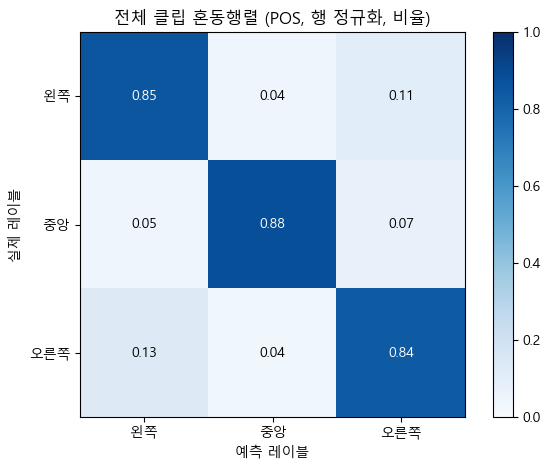


==== OVERALL (클립, UD) ====
Overall 클립 Acc: 0.809 | Balanced Acc: 0.809
              precision    recall  f1-score   support

          아래      0.816     0.800     0.808       100
           위      0.802     0.818     0.810        99

    accuracy                          0.809       199
   macro avg      0.809     0.809     0.809       199
weighted avg      0.809     0.809     0.809       199



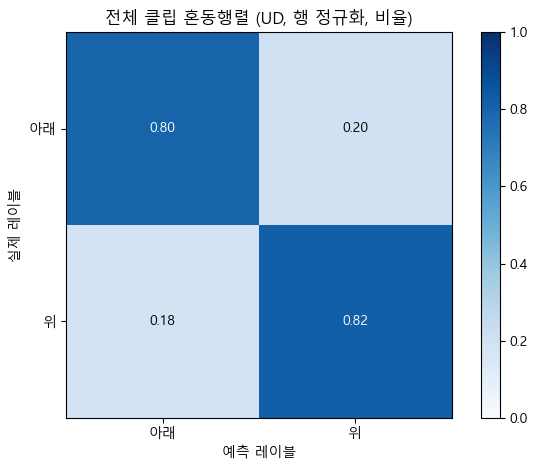

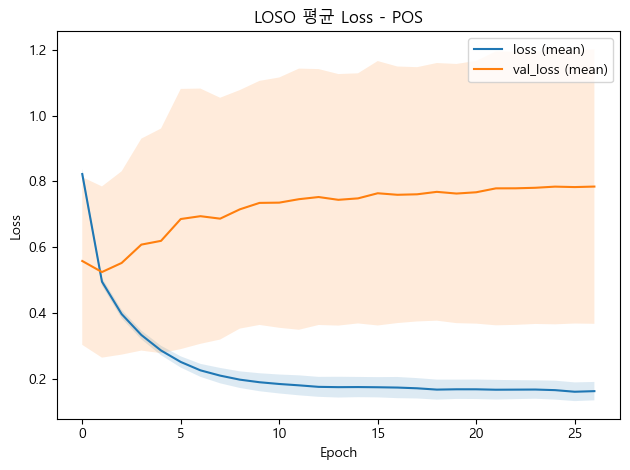

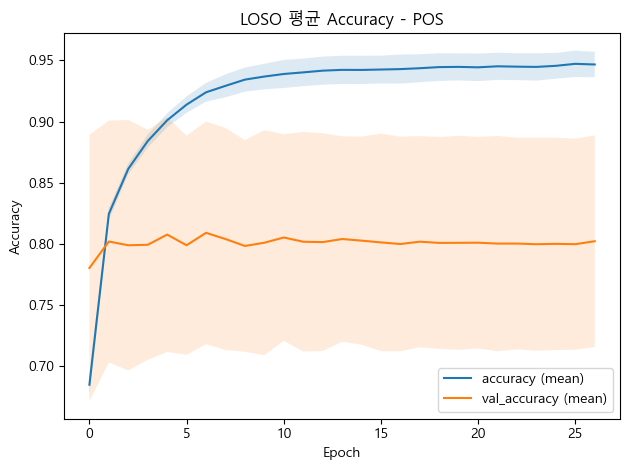

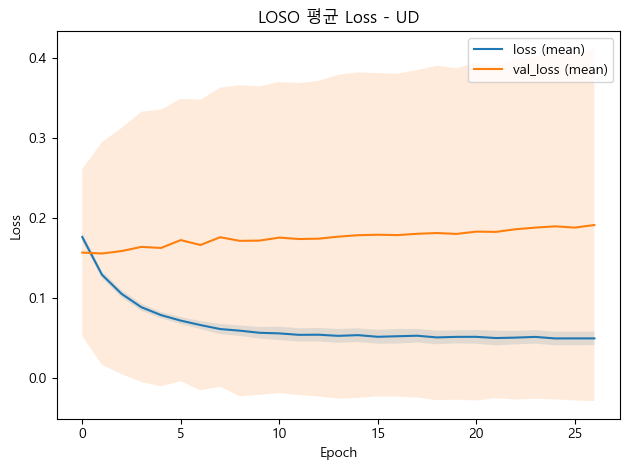

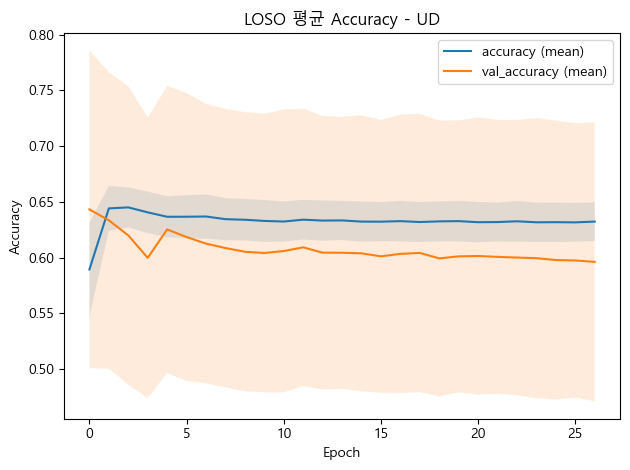

In [122]:
# === LOSO 멀티태스크 학습/평가 (pos + ud, class_weight 미사용: sample_weight로 통일) ===
import os, gc
import numpy as np
from collections import defaultdict
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# ----- 옵션 -----
EPOCHS = 27
BATCH_SIZE = 64
RLR_PATIENCE = 2
PLOT_LAST_FOLD_CURVES = False  # 마지막 폴드 곡선 X, 대신 헤드별 평균 곡선 O

# 클래스 이름 (이미 앞에서 정의돼 있어도 동일하게 사용)
POS_NAMES = ['왼쪽','중앙','오른쪽']
UD_NAMES  = ['아래','위']

# histories 평균 플로팅(헤드별)
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves_head(histories, head_name='pos'):
    """헤드별 평균 loss/acc 곡선 그리기 (LOSO 평균 + std band)"""
    loss_key, vloss_key = f'{head_name}_loss', f'val_{head_name}_loss'
    acc_key,  vacc_key  = f'{head_name}_accuracy', f'val_{head_name}_accuracy'

    loss_list     = [h.get(loss_key, []) for h in histories]
    val_loss_list = [h.get(vloss_key, []) for h in histories]
    mean_loss, std_loss         = _nanmean_along_epochs(loss_list)
    mean_val_loss, std_val_loss = _nanmean_along_epochs(val_loss_list)

    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title(f'LOSO 평균 Loss - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    acc_list     = [h.get(acc_key, []) for h in histories]
    val_acc_list = [h.get(vacc_key, []) for h in histories]
    mean_acc, std_acc         = _nanmean_along_epochs(acc_list)
    mean_val_acc, std_val_acc = _nanmean_along_epochs(val_acc_list)

    if mean_acc is not None:
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title(f'LOSO 평균 Accuracy - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

# 행 정규화 혼동행렬(이미 전 셀에 plot_confmat_ratio가 있으면 그걸 써도 OK)
def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

# ----- 준비 -----
persons = np.array([m["person"] for m in meta])
logo = LeaveOneGroupOut()
F = X.shape[-1]
HAND_DIMS = min(42, F)

histories = []
pos_win_accs, pos_clip_accs = [], []
ud_win_accs,  ud_clip_accs  = [], []
# 전체(모든 폴드) 클립 단위 예측/정답 누적
pos_clip_true_all, pos_clip_pred_all = [], []
ud_clip_true_all,  ud_clip_pred_all  = [], []

fold_no = 0
total_folds = len(np.unique(persons))

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1
    tf.keras.backend.clear_session(); gc.collect()

    # --- Split ---
    Xtr, Xva = X[train_idx], X[val_idx]
    y_pos_tr, y_pos_va = y_pos_all[train_idx], y_pos_all[val_idx]
    y_ud_tr,  y_ud_va  = y_ud_all_clipped[train_idx], y_ud_all_clipped[val_idx]
    sw_ud_tr, sw_ud_va = ud_valid_mask_all[train_idx], ud_valid_mask_all[val_idx]  # 1:유효, 0:NA

    # --- 스케일러 (train 활성 프레임 기반 fit → 전체 변환) ---
    scaler = fit_scaler_on_active(Xtr, F, hand_dims=HAND_DIMS, eps=1e-7)
    Xtr_s = scaler.transform(Xtr.reshape(-1, F)).reshape(Xtr.shape)
    Xva_s = scaler.transform(Xva.reshape(-1, F)).reshape(Xva.shape)

    # --- 클래스 불균형 보정: per-sample weight ---
    # POS
    pos_counts = np.bincount(y_pos_tr, minlength=3)
    pos_median = float(np.median(pos_counts[pos_counts > 0])) if (pos_counts > 0).any() else 1.0
    pos_weights_per_class = np.array([pos_median / max(c, 1) for c in pos_counts], dtype=np.float32)
    sw_pos_tr = np.ones(len(y_pos_tr), dtype=np.float32)
    for cls_idx, w in enumerate(pos_weights_per_class):
        sw_pos_tr[y_pos_tr == cls_idx] = w

    # UD (유효 샘플만 카운트)
    ud_tr_valid = y_ud_tr[sw_ud_tr.astype(bool)]
    if len(ud_tr_valid) > 0:
        ud_counts = np.bincount(ud_tr_valid, minlength=2)
        ud_median = float(np.median(ud_counts[ud_counts > 0])) if (ud_counts > 0).any() else 1.0
        ud_weights_per_class = np.array([ud_median / max(c, 1) for c in ud_counts], dtype=np.float32)
    else:
        ud_weights_per_class = np.array([1.0, 1.0], dtype=np.float32)

    sw_ud_tr_full = np.ones(len(y_ud_tr), dtype=np.float32)
    for cls_idx, w in enumerate(ud_weights_per_class):
        sw_ud_tr_full[y_ud_tr == cls_idx] = w
    sw_ud_tr_full *= sw_ud_tr.astype(np.float32)  # NA=0 마스킹

    # --- 모델 ---
    model = build_multitask_model(input_shape=(Xtr_s.shape[1], Xtr_s.shape[2]))

    # 콜백
    best_w_path = f'_tmp_mtl_best_fold{fold_no:02d}.weights.h5'
    cbs = [
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.ModelCheckpoint(filepath=best_w_path, monitor='val_loss',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    ]

    # --- 학습 ---
    sw_valid = {
        'pos': np.ones(len(Xva_s), dtype=np.float32),
        'ud' : sw_ud_va.astype(np.float32)  # UD는 NA=0으로 마스킹
    }
    history = model.fit(
        Xtr_s,
        {'pos': y_pos_tr, 'ud': y_ud_tr},
        validation_data=(Xva_s, {'pos': y_pos_va, 'ud': y_ud_va}, sw_valid),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        sample_weight={'pos': sw_pos_tr, 'ud': sw_ud_tr_full},
        callbacks=cbs, verbose=1
    )

    # 베스트 가중치 로드
    if os.path.exists(best_w_path):
        model.load_weights(best_w_path)
        try: os.remove(best_w_path)
        except: pass

    histories.append(history.history)

    # --- 예측 ---
    p_pos_va, p_ud_va = model.predict(Xva_s, verbose=0)
    y_pos_pred = p_pos_va.argmax(1)
    y_ud_pred  = p_ud_va.argmax(1)

    # 윈도우 Acc
    pos_win_accs.append(accuracy_score(y_pos_va, y_pos_pred))
    if sw_ud_va.sum() > 0:
        mask = sw_ud_va.astype(bool)
        ud_win_accs.append(accuracy_score(y_ud_va[mask], y_ud_pred[mask]))

    # --- 클립 집계(확률 평균) ---
    val_meta = [meta[i] for i in val_idx]

    # POS
    bucket_pos, bucket_pos_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        bucket_pos[m["src"]].append(p_pos_va[i])
        bucket_pos_y[m["src"]] = y_pos_va[i]
    pos_P_clip, pos_Y_clip = [], []
    for src, ps in bucket_pos.items():
        pos_P_clip.append(np.mean(ps, axis=0))
        pos_Y_clip.append(bucket_pos_y[src])
    pos_clip_pred = np.argmax(np.vstack(pos_P_clip), axis=1)
    pos_clip_accs.append(accuracy_score(pos_Y_clip, pos_clip_pred))
    pos_clip_true_all.append(np.array(pos_Y_clip))
    pos_clip_pred_all.append(pos_clip_pred)

    # UD (유효 클립만)
    bucket_ud, bucket_ud_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        if sw_ud_va[i] > 0.5:
            bucket_ud[m["src"]].append(p_ud_va[i])
            bucket_ud_y[m["src"]] = y_ud_va[i]
    if len(bucket_ud) > 0:
        ud_P_clip, ud_Y_clip = [], []
        for src, ps in bucket_ud.items():
            ud_P_clip.append(np.mean(ps, axis=0))
            ud_Y_clip.append(bucket_ud_y[src])
        ud_clip_pred = np.argmax(np.vstack(ud_P_clip), axis=1)
        ud_clip_accs.append(accuracy_score(ud_Y_clip, ud_clip_pred))
        ud_clip_true_all.append(np.array(ud_Y_clip))
        ud_clip_pred_all.append(ud_clip_pred)

# ===== 집계 출력 =====
pos_clip_true_all = np.concatenate(pos_clip_true_all, axis=0) if len(pos_clip_true_all)>0 else np.array([])
pos_clip_pred_all = np.concatenate(pos_clip_pred_all, axis=0) if len(pos_clip_pred_all)>0 else np.array([])
ud_clip_true_all  = np.concatenate(ud_clip_true_all, axis=0)  if len(ud_clip_true_all)>0  else np.array([])
ud_clip_pred_all  = np.concatenate(ud_clip_pred_all, axis=0)  if len(ud_clip_pred_all)>0  else np.array([])

print("\n==== POS(왼/중/오) ====")
print(f"Win Acc:  {np.mean(pos_win_accs):.3f} ± {np.std(pos_win_accs):.3f}")
print(f"Clip Acc: {np.mean(pos_clip_accs):.3f} ± {np.std(pos_clip_accs):.3f}")

if len(ud_win_accs) > 0:
    print("\n==== UD(아래/위, 유효 샘플만) ====")
    print(f"Win Acc:  {np.mean(ud_win_accs):.3f} ± {np.std(ud_win_accs):.3f}")
if len(ud_clip_accs) > 0:
    print(f"Clip Acc: {np.mean(ud_clip_accs):.3f} ± {np.std(ud_clip_accs):.3f}")

# ---- 헤드별 Overall(클립) 리포트 & 혼동행렬 ----
from sklearn.metrics import balanced_accuracy_score

# POS
if pos_clip_true_all.size > 0:
    pos_overall_acc = accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    pos_bal_acc     = balanced_accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    print("\n==== OVERALL (클립, POS) ====")
    print(f"Overall 클립 Acc: {pos_overall_acc:.3f} | Balanced Acc: {pos_bal_acc:.3f}")
    print(classification_report(pos_clip_true_all, pos_clip_pred_all, target_names=POS_NAMES, digits=3))
    cm_pos = confusion_matrix(pos_clip_true_all, pos_clip_pred_all, labels=[0,1,2])
    plot_confmat_ratio(cm_pos, POS_NAMES, '전체 클립 혼동행렬 (POS, 행 정규화, 비율)')

# UD
if ud_clip_true_all.size > 0:
    ud_overall_acc = accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    ud_bal_acc     = balanced_accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    print("\n==== OVERALL (클립, UD) ====")
    print(f"Overall 클립 Acc: {ud_overall_acc:.3f} | Balanced Acc: {ud_bal_acc:.3f}")
    print(classification_report(ud_clip_true_all, ud_clip_pred_all, target_names=UD_NAMES, digits=3))
    cm_ud = confusion_matrix(ud_clip_true_all, ud_clip_pred_all, labels=[0,1])
    plot_confmat_ratio(cm_ud, UD_NAMES, '전체 클립 혼동행렬 (UD, 행 정규화, 비율)')

# ---- 헤드별 LOSO 평균 곡선 ----
plot_mean_training_curves_head(histories, head_name='pos')
plot_mean_training_curves_head(histories, head_name='ud')


**각도 추가, stride 5, 에포크 40**

In [ ]:
# === 기본 설정 & 임포트 ===
import os, glob, json, math, random, gc
import numpy as np
from collections import defaultdict
from statistics import mean

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ★ 사용자 설정
PROJECT_TAG   = "v4_angle"                  # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()           # 노트북 위치 기준
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일; 13-class)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN = 30      # 2초 창 (15fps * 2s)
STRIDE  = 5      
MIN_ACTIVE_RATIO   = 0.20 # 창 내 손-검출 프레임 비율 하한
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# === 윈도잉 & 마스크 유틸 ===
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)
    return (e > eps).astype(np.float32)[:, None]

def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F) -> [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    손 좌표(앞 hand_dims)를 프레임별로 검사하여 non-zero 프레임 비율 반환
    """
    H = min(hand_dims, win.shape[1])
    fr = win[:, :H]
    nz = (np.abs(fr).sum(axis=1) > eps)
    return nz.mean()

# === 매니페스트 스캔 ===
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir):
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir):
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            if arr.ndim != 2:
                print(f"[warn] skip non-2D: {npy}, shape={arr.shape}")
                continue
            T, F = arr.shape
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

print("총 manifest:", len(manifest))
if len(manifest) == 0:
    raise RuntimeError("manifest가 비었습니다. 데이터 경로/구조를 확인하세요.")

# === 데이터 전역 통계 ===
feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)

# === 윈도 생성 및 필터링 ===
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    if arr.ndim != 2 or arr.shape[1] != FEAT_DIM:
        print(f"[warn] Skip due to wrong dim: {m['path']}, shape={arr.shape}")
        continue

    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue

    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                             # (L, F)
            M.append(frame_active_mask(w))          # (L, 1)  - 현재 학습엔 미사용(옵션)
            y.append(m["y"])                        # 13-class
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)  # (옵션) 현재 미사용
y = np.array(y)           # (N,)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)

# === 13→3 매핑 ===
labels_np = np.array(KOREAN_LABELS, dtype=object)
lab_to_group = {l: ('왼쪽' if l.startswith('왼쪽') else '중앙' if l.startswith('중앙') else '오른쪽') for l in labels_np}
group_to_idx = {'왼쪽':0, '중앙':1, '오른쪽':2}
CLASS_NAMES  = ['왼쪽','중앙','오른쪽']

def map_y_to_3(y13):
    return np.array([group_to_idx[lab_to_group[labels_np[i]]] for i in y13])

# 미리 3클래스 타깃 전체 계산(폴드 내 인덱싱만 수행)
y3_all = map_y_to_3(y)

# === 스케일러 fit 유틸 (활성 프레임만) ===
from sklearn.preprocessing import StandardScaler
def fit_scaler_on_active(X_train, F, hand_dims=42, eps=1e-7):
    Xtr_flat = X_train.reshape(-1, F)
    H = min(hand_dims, F)
    mask = (np.abs(Xtr_flat[:, :H]).sum(axis=1) > eps)
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    return scaler

# === 플롯 유틸 ===
import matplotlib.pyplot as plt
from matplotlib import font_manager

def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

def plot_training_curves(history, fold_no):
    H = history.history
    plt.figure(); plt.plot(H.get('loss', []),     label='loss'); plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'Fold {fold_no} - Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure(); plt.plot(H['accuracy'], label='accuracy'); plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'Fold {fold_no} - Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()

def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories):
    mean_loss, std_loss         = _nanmean_along_epochs([h['loss'] for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h['val_loss'] for h in histories])
    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss,     mean_loss + std_loss,     alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title('LOSO 평균 Loss (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy'] for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc,     mean_acc + std_acc,     alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title('LOSO 평균 Accuracy (에포크 기준)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


총 manifest: 1085
Feature dims found: [62]
Clips: 1085, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 62
Windows kept: 27122, dropped_short: 0, dropped_inactive: 0
X shape: (27122, 30, 62) M shape: (27122, 30, 1) y shape: (27122,)


In [137]:
# === 13→태스크 라벨 매핑 (pos=왼/중/오, ud=아래/위/NA) ===
import numpy as np

POS_NAMES = ['왼쪽','중앙','오른쪽']   # head #1
UD_NAMES  = ['아래','위']            # head #2 (씹는면만 유효, 나머지는 NA)

labels_np = np.array(KOREAN_LABELS, dtype=object)

def _pos_from_label(lab: str) -> int:
    if lab.startswith('왼쪽'):   return 0
    if lab.startswith('중앙'):   return 1
    if lab.startswith('오른쪽'): return 2
    raise ValueError(f"Unexpected label for pos: {lab}")

def _ud_from_label(lab: str) -> int:
    # 씹는면
    if '씹는면' in lab:
        return 1 if '위' in lab else 0
    # 구개측은 위쪽
    if '구개측' in lab:
        return 1
    # 설측은 아래쪽
    if '설측' in lab:
        return 0
    # 협측은 NA
    return -1

# 전체 샘플에 대해 태스크 라벨 생성
y_pos_all = np.array([_pos_from_label(labels_np[i]) for i in y], dtype=np.int64)
y_ud_all  = np.array([_ud_from_label(labels_np[i])  for i in y], dtype=np.int64)

# ud 유효/무효 마스크 (1:유효, 0:무효)
ud_valid_mask_all = (y_ud_all != -1).astype(np.float32)

# Keras는 -1 라벨 불가 → 더미 0으로 대체하고, 손실은 sample_weight로 마스킹
y_ud_all_clipped = np.where(y_ud_all == -1, 0, y_ud_all)


In [138]:
# === GPU 메모리 점진 할당 & 체크(단일) ===
import tensorflow as tf

def setup_and_check_gpu():
    print("TF version:", tf.__version__)
    print("Built with CUDA:", tf.test.is_built_with_cuda())

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print("set_memory_growth 실패:", e)
        logical = tf.config.list_logical_devices('GPU')
        names = []
        for gpu in gpus:
            try:
                info = tf.config.experimental.get_device_details(gpu)
                names.append(info.get('device_name', gpu.name))
            except:
                names.append(getattr(gpu, 'name', 'GPU'))
        print(f"GPU 인식됨: 물리 {len(gpus)}개 / 논리 {len(logical)}개")
        print("GPU 이름:", names)
    else:
        print("GPU 미인식 → CPU로 학습합니다.")

setup_and_check_gpu()

# TensorFlow seed 고정
tf.random.set_seed(SEED)


TF version: 2.10.0
Built with CUDA: True
GPU 인식됨: 물리 1개 / 논리 1개
GPU 이름: ['NVIDIA GeForce RTX 4070']


In [139]:
# === 멀티태스크 모델 빌더 (공유 인코더 + pos/ud 두 헤드) ===
from tensorflow.keras import layers, regularizers
import tensorflow as tf

def build_multitask_model(input_shape):
    """
    공유 인코더 + pos(3), ud(2) 두 헤드
    """
    inp = layers.Input(shape=input_shape, name='inp')

    # --- 공유 인코더 (기존 단일태스크와 동일 설정) ---
    x = layers.GaussianNoise(0.01, name='enc_noise')(inp)
    x = layers.SpatialDropout1D(0.2, name='enc_sdrop')(x)

    x = layers.GRU(
        96, return_sequences=True, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru1'
    )(x)
    x = layers.GRU(
        64, return_sequences=False, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru2'
    )(x)

    x = layers.BatchNormalization(name='enc_bn')(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name='enc_fc')(x)
    x = layers.Dropout(0.5, name='enc_drop')(x)

    # --- Head #1: pos(왼/중/오) ---
    pos_out = layers.Dense(3, activation='softmax', name='pos')(x)

    # --- Head #2: ud(아래/위) ---
    ud_out  = layers.Dense(2, activation='softmax', name='ud')(x)

    model = tf.keras.Model(inp, [pos_out, ud_out])

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss={'pos': tf.keras.losses.SparseCategoricalCrossentropy(),
              'ud':  tf.keras.losses.SparseCategoricalCrossentropy()},
        metrics={'pos': ['accuracy'], 'ud': ['accuracy']},
        loss_weights={'pos': 1.0, 'ud': 1.0}
    )
    return model


# === 멀티태스크 모델 요약 출력 ===
tmp = build_multitask_model(input_shape=(SEQ_LEN, FEAT_DIM))
tmp.summary(line_length=120, expand_nested=False, show_trainable=True)


Model: "model_3"
___________________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            Trainable  
 inp (InputLayer)                      [(None, 30, 62)]           0             []                                      Y          
                                                                                                                                   
 enc_noise (GaussianNoise)             (None, 30, 62)             0             ['inp[0][0]']                           Y          
                                                                                                                                   
 enc_sdrop (SpatialDropout1D)          (None, 30, 62)             0             ['enc_noise[0][0]']                     Y          
                                                           

Epoch 1/40
399/399 [==============================] - 7s 12ms/step - loss: 1.2603 - pos_loss: 0.7794 - ud_loss: 0.4358 - pos_accuracy: 0.7030 - ud_accuracy: 0.7229 - val_loss: 0.6040 - val_pos_loss: 0.2946 - val_ud_loss: 0.2643 - val_pos_accuracy: 0.9292 - val_ud_accuracy: 0.8886 - lr: 3.0000e-04
Epoch 2/40
399/399 [==============================] - 4s 10ms/step - loss: 0.8356 - pos_loss: 0.4658 - ud_loss: 0.3245 - pos_accuracy: 0.8373 - ud_accuracy: 0.7710 - val_loss: 0.3343 - val_pos_loss: 0.1016 - val_ud_loss: 0.1871 - val_pos_accuracy: 0.9828 - val_ud_accuracy: 0.8929 - lr: 3.0000e-04
Epoch 3/40
399/399 [==============================] - 4s 10ms/step - loss: 0.6720 - pos_loss: 0.3585 - ud_loss: 0.2677 - pos_accuracy: 0.8765 - ud_accuracy: 0.7815 - val_loss: 0.2906 - val_pos_loss: 0.0700 - val_ud_loss: 0.1744 - val_pos_accuracy: 0.9883 - val_ud_accuracy: 0.8892 - lr: 3.0000e-04
Epoch 4/40
399/399 [==============================] - 4s 10ms/step - loss: 0.5821 - pos_loss: 0.3058 - ud_

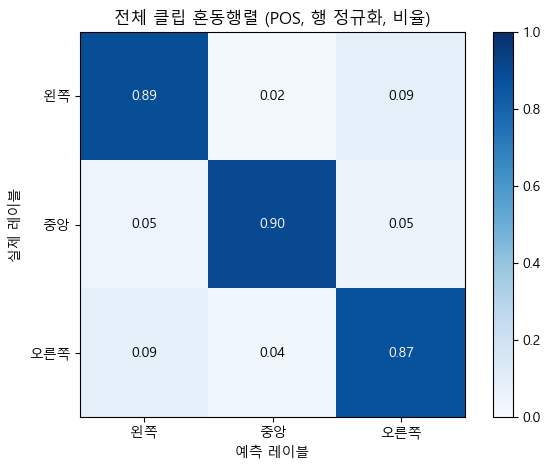


==== OVERALL (클립, UD) ====
Overall 클립 Acc: 0.831 | Balanced Acc: 0.831
              precision    recall  f1-score   support

          아래      0.829     0.839     0.834       411
           위      0.833     0.823     0.828       401

    accuracy                          0.831       812
   macro avg      0.831     0.831     0.831       812
weighted avg      0.831     0.831     0.831       812



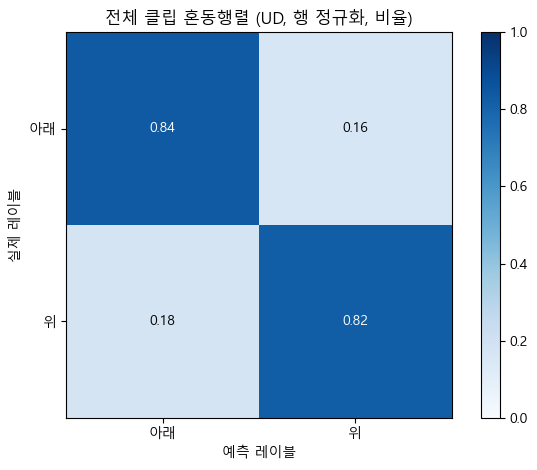

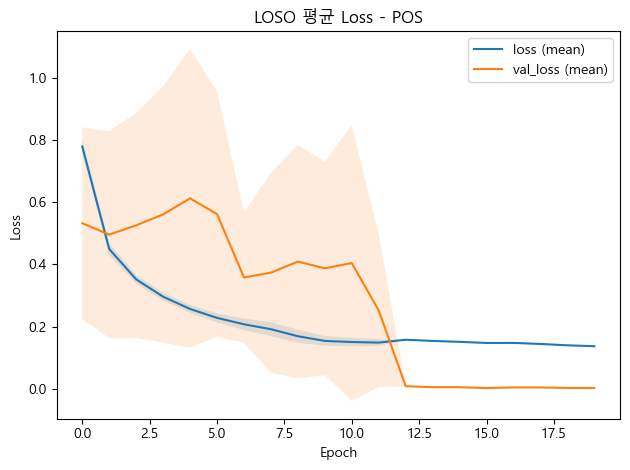

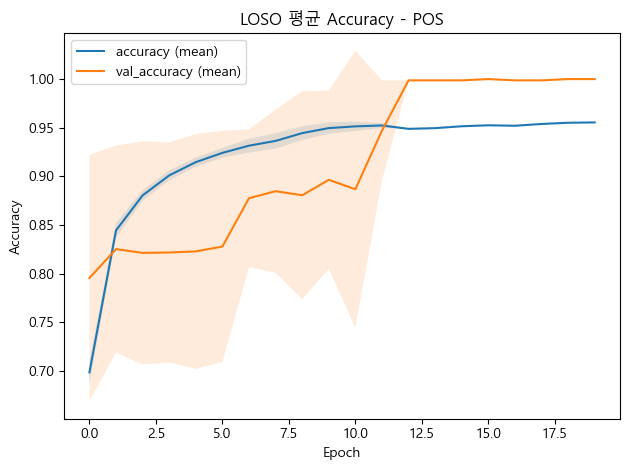

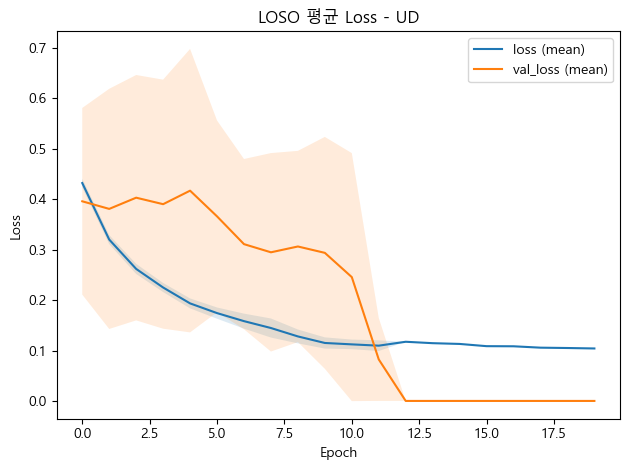

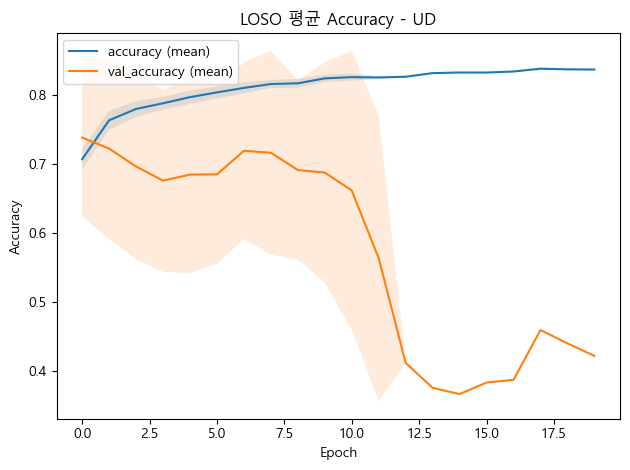

In [140]:
# === LOSO 멀티태스크 학습/평가 (pos + ud, class_weight 미사용: sample_weight로 통일) ===
import os, gc
import numpy as np
from collections import defaultdict
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

# === 과적합 지표 유틸 (새 셀 추가) ===
import numpy as np
import matplotlib.pyplot as plt

def compute_overfit_indices(history_dict, head_name='pos'):
    """
    반환:
      gap_loss = val_loss - loss  (양수↑ = 과적합 경향)
      gap_acc  = train_acc - val_acc (양수↑ = 과적합 경향)
    """
    hd = history_dict
    gap = {'gap_loss': [], 'gap_acc': []}
    l_key, vl_key = f'{head_name}_loss', f'val_{head_name}_loss'
    a_key, va_key = f'{head_name}_accuracy', f'val_{head_name}_accuracy'
    L  = hd.get(l_key, [])
    VL = hd.get(vl_key, [])
    A  = hd.get(a_key, [])
    VA = hd.get(va_key, [])
    for i in range(min(len(L), len(VL))):
        gap['gap_loss'].append(VL[i] - L[i])
    for i in range(min(len(A), len(VA))):
        gap['gap_acc'].append(A[i] - VA[i])
    return gap

def plot_overfit_gaps(history_dict, fold_no, heads=('pos','ud')):
    """폴드별 generalization gap 플롯 (원하면 호출)"""
    for head in heads:
        gp = compute_overfit_indices(history_dict, head)
        xL = np.arange(len(gp['gap_loss']))
        xA = np.arange(len(gp['gap_acc']))
        if len(xL) > 0:
            plt.figure()
            plt.plot(xL, gp['gap_loss'], label=f'gap_loss {head} (val - train)')
            if len(xA) == len(xL):
                plt.plot(xA, gp['gap_acc'],  label=f'gap_acc  {head} (train - val)')
            plt.axhline(0, linewidth=1)
            plt.title(f'Fold {fold_no} - Generalization Gaps ({head.upper()})')
            plt.xlabel('Epoch'); plt.legend(); plt.tight_layout(); plt.show()

def simple_overfit_flag(history_dict, head='pos', th_gap_loss=0.20, th_gap_acc=0.10, last_k=3):
    """
    마지막 k 에포크 평균으로 간단 플래그.
    return: (flag, {'gap_loss':float, 'gap_acc':float})
    """
    gp = compute_overfit_indices(history_dict, head)
    if not gp['gap_loss'] or not gp['gap_acc']:
        return False, {'gap_loss': None, 'gap_acc': None}
    k = min(last_k, len(gp['gap_loss']), len(gp['gap_acc']))
    gl = float(np.mean(gp['gap_loss'][-k:]))
    ga = float(np.mean(gp['gap_acc'][-k:]))
    flag = (gl > th_gap_loss) and (ga > th_gap_acc)
    return flag, {'gap_loss': gl, 'gap_acc': ga}


# ----- 옵션 -----
EPOCHS = 40
BATCH_SIZE = 64
RLR_PATIENCE = 2
ES_PATIENCE  = 4           # EarlyStopping 추가
PLOT_LAST_FOLD_CURVES = False  # 마지막 폴드 개별 곡선은 생략(평균 곡선은 따로 있음)

# 클래스 이름
POS_NAMES = ['왼쪽','중앙','오른쪽']
UD_NAMES  = ['아래','위']

# ----- 준비 -----
persons = np.array([m["person"] for m in meta])
logo = LeaveOneGroupOut()
F = X.shape[-1]
HAND_DIMS = min(42, F)

histories = []
pos_win_accs, pos_clip_accs = [], []
ud_win_accs,  ud_clip_accs  = [], []
# 전체(모든 폴드) 클립 단위 예측/정답 누적
pos_clip_true_all, pos_clip_pred_all = [], []
ud_clip_true_all,  ud_clip_pred_all  = [], []

fold_no = 0
total_folds = len(np.unique(persons))

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1
    tf.keras.backend.clear_session(); gc.collect()

    # --- Split ---
    Xtr, Xva = X[train_idx], X[val_idx]
    y_pos_tr, y_pos_va = y_pos_all[train_idx], y_pos_all[val_idx]
    y_ud_tr,  y_ud_va  = y_ud_all_clipped[train_idx], y_ud_all_clipped[val_idx]
    sw_ud_tr, sw_ud_va = ud_valid_mask_all[train_idx], ud_valid_mask_all[val_idx]  # 1:유효, 0:NA

    # --- 스케일러 (train 활성 프레임 기반 fit → 전체 변환) ---
    scaler = fit_scaler_on_active(Xtr, F, hand_dims=HAND_DIMS, eps=1e-7)
    Xtr_s = scaler.transform(Xtr.reshape(-1, F)).reshape(Xtr.shape)
    Xva_s = scaler.transform(Xva.reshape(-1, F)).reshape(Xva.shape)

    # --- 클래스 불균형 보정: per-sample weight ---
    # POS
    pos_counts = np.bincount(y_pos_tr, minlength=3)
    pos_median = float(np.median(pos_counts[pos_counts > 0])) if (pos_counts > 0).any() else 1.0
    pos_weights_per_class = np.array([pos_median / max(c, 1) for c in pos_counts], dtype=np.float32)
    sw_pos_tr = np.ones(len(y_pos_tr), dtype=np.float32)
    for cls_idx, w in enumerate(pos_weights_per_class):
        sw_pos_tr[y_pos_tr == cls_idx] = w

    # UD (유효 샘플만 카운트)
    ud_tr_valid = y_ud_tr[sw_ud_tr.astype(bool)]
    if len(ud_tr_valid) > 0:
        ud_counts = np.bincount(ud_tr_valid, minlength=2)
        ud_median = float(np.median(ud_counts[ud_counts > 0])) if (ud_counts > 0).any() else 1.0
        ud_weights_per_class = np.array([ud_median / max(c, 1) for c in ud_counts], dtype=np.float32)
    else:
        ud_weights_per_class = np.array([1.0, 1.0], dtype=np.float32)

    sw_ud_tr_full = np.ones(len(y_ud_tr), dtype=np.float32)
    for cls_idx, w in enumerate(ud_weights_per_class):
        sw_ud_tr_full[y_ud_tr == cls_idx] = w
    sw_ud_tr_full *= sw_ud_tr.astype(np.float32)  # NA=0 마스킹

    # --- 모델 ---
    model = build_multitask_model(input_shape=(Xtr_s.shape[1], Xtr_s.shape[2]))

    # 콜백 (EarlyStopping 추가)
    best_w_path = f'_tmp_mtl_best_fold{fold_no:02d}.weights.h5'
    cbs = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=best_w_path, monitor='val_loss',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    ]

    # --- 학습 ---
    sw_valid = {
        'pos': np.ones(len(Xva_s), dtype=np.float32),
        'ud' : sw_ud_va.astype(np.float32)  # UD는 NA=0으로 마스킹
    }
    history = model.fit(
        Xtr_s,
        {'pos': y_pos_tr, 'ud': y_ud_tr},
        validation_data=(Xva_s, {'pos': y_pos_va, 'ud': y_ud_va}, sw_valid),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        sample_weight={'pos': sw_pos_tr, 'ud': sw_ud_tr_full},
        callbacks=cbs, verbose=1
    )

    # 베스트 가중치 보장
    if os.path.exists(best_w_path):
        model.load_weights(best_w_path)
        try: os.remove(best_w_path)
        except: pass

    histories.append(history.history)

    # --- 과적합 지표/경고 출력 (마지막 k 에포크 평균) ---
    flag_pos, gpos = simple_overfit_flag(history.history, head='pos', th_gap_loss=0.20, th_gap_acc=0.10, last_k=3)
    flag_ud,  gud  = simple_overfit_flag(history.history, head='ud',  th_gap_loss=0.20, th_gap_acc=0.10, last_k=3)
    print(f"[Fold {fold_no}] Overfit check - POS: flag={flag_pos}, last_k_gap={{loss:{gpos['gap_loss']:.3f}, acc:{gpos['gap_acc']:.3f}}}")
    print(f"[Fold {fold_no}] Overfit check -  UD: flag={flag_ud},  last_k_gap={{loss:{gud['gap_loss']:.3f}, acc:{gud['gap_acc']:.3f}}}")
    # 필요 시 갭 곡선 시각화
    # plot_overfit_gaps(history.history, fold_no)

    # --- 예측 ---
    p_pos_va, p_ud_va = model.predict(Xva_s, verbose=0)
    y_pos_pred = p_pos_va.argmax(1)
    y_ud_pred  = p_ud_va.argmax(1)

    # 윈도우 Acc
    pos_win_accs.append(accuracy_score(y_pos_va, y_pos_pred))
    if sw_ud_va.sum() > 0:
        mask = sw_ud_va.astype(bool)
        ud_win_accs.append(accuracy_score(y_ud_va[mask], y_ud_pred[mask]))

    # --- 클립 집계(확률 평균) ---
    val_meta = [meta[i] for i in val_idx]

    # POS
    bucket_pos, bucket_pos_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        bucket_pos[m["src"]].append(p_pos_va[i])
        bucket_pos_y[m["src"]] = y_pos_va[i]
    pos_P_clip, pos_Y_clip = [], []
    for src, ps in bucket_pos.items():
        pos_P_clip.append(np.mean(ps, axis=0))
        pos_Y_clip.append(bucket_pos_y[src])
    pos_clip_pred = np.argmax(np.vstack(pos_P_clip), axis=1)
    pos_clip_accs.append(accuracy_score(pos_Y_clip, pos_clip_pred))
    pos_clip_true_all.append(np.array(pos_Y_clip))
    pos_clip_pred_all.append(pos_clip_pred)

    # UD (유효 클립만)
    bucket_ud, bucket_ud_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        if sw_ud_va[i] > 0.5:
            bucket_ud[m["src"]].append(p_ud_va[i])
            bucket_ud_y[m["src"]] = y_ud_va[i]
    if len(bucket_ud) > 0:
        ud_P_clip, ud_Y_clip = [], []
        for src, ps in bucket_ud.items():
            ud_P_clip.append(np.mean(ps, axis=0))
            ud_Y_clip.append(bucket_ud_y[src])
        ud_clip_pred = np.argmax(np.vstack(ud_P_clip), axis=1)
        ud_clip_accs.append(accuracy_score(ud_Y_clip, ud_clip_pred))
        ud_clip_true_all.append(np.array(ud_Y_clip))
        ud_clip_pred_all.append(ud_clip_pred)

# ===== 집계 출력 =====
pos_clip_true_all = np.concatenate(pos_clip_true_all, axis=0) if len(pos_clip_true_all)>0 else np.array([])
pos_clip_pred_all = np.concatenate(pos_clip_pred_all, axis=0) if len(pos_clip_pred_all)>0 else np.array([])
ud_clip_true_all  = np.concatenate(ud_clip_true_all, axis=0)  if len(ud_clip_true_all)>0  else np.array([])
ud_clip_pred_all  = np.concatenate(ud_clip_pred_all, axis=0)  if len(ud_clip_pred_all)>0  else np.array([])

print("\n==== POS(왼/중/오) ====")
print(f"Win Acc:  {np.mean(pos_win_accs):.3f} ± {np.std(pos_win_accs):.3f}")
print(f"Clip Acc: {np.mean(pos_clip_accs):.3f} ± {np.std(pos_clip_accs):.3f}")

if len(ud_win_accs) > 0:
    print("\n==== UD(아래/위, 유효 샘플만) ====")
    print(f"Win Acc:  {np.mean(ud_win_accs):.3f} ± {np.std(ud_win_accs):.3f}")
if len(ud_clip_accs) > 0:
    print(f"Clip Acc: {np.mean(ud_clip_accs):.3f} ± {np.std(ud_clip_accs):.3f}")

# ---- 헤드별 Overall(클립) 리포트 & 혼동행렬 ----
if pos_clip_true_all.size > 0:
    pos_overall_acc = accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    pos_bal_acc     = balanced_accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    print("\n==== OVERALL (클립, POS) ====")
    print(f"Overall 클립 Acc: {pos_overall_acc:.3f} | Balanced Acc: {pos_bal_acc:.3f}")
    print(classification_report(pos_clip_true_all, pos_clip_pred_all, target_names=POS_NAMES, digits=3))
    cm_pos = confusion_matrix(pos_clip_true_all, pos_clip_pred_all, labels=[0,1,2])
    plot_confmat_ratio(cm_pos, POS_NAMES, '전체 클립 혼동행렬 (POS, 행 정규화, 비율)')

if ud_clip_true_all.size > 0:
    ud_overall_acc = accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    ud_bal_acc     = balanced_accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    print("\n==== OVERALL (클립, UD) ====")
    print(f"Overall 클립 Acc: {ud_overall_acc:.3f} | Balanced Acc: {ud_bal_acc:.3f}")
    print(classification_report(ud_clip_true_all, ud_clip_pred_all, target_names=UD_NAMES, digits=3))
    cm_ud = confusion_matrix(ud_clip_true_all, ud_clip_pred_all, labels=[0,1])
    plot_confmat_ratio(cm_ud, UD_NAMES, '전체 클립 혼동행렬 (UD, 행 정규화, 비율)')

# ---- 헤드별 LOSO 평균 곡선 ----
plot_mean_training_curves_head(histories, head_name='pos')
plot_mean_training_curves_head(histories, head_name='ud')


In [1]:
# === 기본 설정 & 임포트 ===
import os, glob, json, math, random, gc
import numpy as np
from collections import defaultdict
from statistics import mean

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ★ 사용자 설정
PROJECT_TAG   = "v4_angle"  # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()  # 노트북 위치 기준
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일; 13-class)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN = 30      # 2초 창 (15fps * 2s)
STRIDE  = 5
MIN_ACTIVE_RATIO   = 0.20 # 창 내 손-검출 프레임 비율 하한
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# === 윈도잉 & 마스크 유틸 ===
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)
    return (e > eps).astype(np.float32)[:, None]

def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F) -> [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    손 좌표(앞 hand_dims)를 프레임별로 검사하여 non-zero 프레임 비율 반환
    """
    H = min(hand_dims, win.shape[1])
    fr = win[:, :H]
    nz = (np.abs(fr).sum(axis=1) > eps)
    return nz.mean()

# === 매니페스트 스캔 ===
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir):
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir):
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            if arr.ndim != 2:
                print(f"[warn] skip non-2D: {npy}, shape={arr.shape}")
                continue
            T, F = arr.shape
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

print("총 manifest:", len(manifest))
if len(manifest) == 0:
    raise RuntimeError("manifest가 비었습니다. 데이터 경로/구조를 확인하세요.")

# === 데이터 전역 통계 ===
feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)

# === 윈도 생성 및 필터링 ===
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    if arr.ndim != 2 or arr.shape[1] != FEAT_DIM:
        print(f"[warn] Skip due to wrong dim: {m['path']}, shape={arr.shape}")
        continue

    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue

    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                             # (L, F)
            M.append(frame_active_mask(w))          # (L, 1)  - (옵션) 현재 미사용
            y.append(m["y"])                        # 13-class
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)
y = np.array(y)           # (N,)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)

# === 13→태스크 라벨 매핑 (pos=왼/중/오, ud=아래/위/NA) ===
import numpy as np

POS_NAMES = ['왼쪽','중앙','오른쪽']   # head #1
UD_NAMES  = ['아래','위']            # head #2 (씹는면/설·구개는 규칙으로 투영)

labels_np = np.array(KOREAN_LABELS, dtype=object)

def _pos_from_label(lab: str) -> int:
    if lab.startswith('왼쪽'):   return 0
    if lab.startswith('중앙'):   return 1
    if lab.startswith('오른쪽'): return 2
    raise ValueError(f"Unexpected label for pos: {lab}")

def _ud_from_label(lab: str) -> int:
    # 씹는면
    if '씹는면' in lab:
        return 1 if '위' in lab else 0
    # 구개측은 위쪽
    if '구개측' in lab:
        return 1
    # 설측은 아래쪽
    if '설측' in lab:
        return 0
    # 협측은 NA
    return -1

# 전체 샘플에 대해 태스크 라벨 생성
y_pos_all = np.array([_pos_from_label(labels_np[i]) for i in y], dtype=np.int64)
y_ud_all  = np.array([_ud_from_label(labels_np[i])  for i in y], dtype=np.int64)

# ud 유효/무효 마스크 (1:유효, 0:무효)
ud_valid_mask_all = (y_ud_all != -1).astype(np.float32)

# Keras는 -1 라벨 불가 → 더미 0으로 대체하고, 손실은 sample_weight로 마스킹
y_ud_all_clipped = np.where(y_ud_all == -1, 0, y_ud_all)

# === 스케일러 fit 유틸 (활성 프레임만) ===
from sklearn.preprocessing import StandardScaler

def fit_scaler_on_active(X_train, F, hand_dims=42, eps=1e-7):
    Xtr_flat = X_train.reshape(-1, F)
    H = min(hand_dims, F)
    mask = (np.abs(Xtr_flat[:, :H]).sum(axis=1) > eps)
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    return scaler

# === 플롯 유틸 ===
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

# --- 공통: NaN 패딩 평균/표준편차 ---
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

# --- 단일 폴드 디버그용(옵션) ---
def plot_training_curves(history, fold_no, head_name=None):
    H = history.history if hasattr(history, "history") else history
    if head_name is None:
        plt.figure()
        plt.plot(H.get('loss', []), label='loss')
        plt.plot(H.get('val_loss', []), label='val_loss')
        plt.title(f'Fold {fold_no} - Total Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        lkey, vlkey = f'{head_name}_loss', f'val_{head_name}_loss'
        akey, vakey = f'{head_name}_accuracy', f'val_{head_name}_accuracy'
        if lkey in H and vlkey in H:
            plt.figure()
            plt.plot(H[lkey],  label=lkey)
            plt.plot(H[vlkey], label=vlkey)
            plt.title(f'Fold {fold_no} - Loss ({head_name.upper()})'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
        if akey in H and vakey in H:
            plt.figure()
            plt.plot(H[akey],  label=akey)
            plt.plot(H[vakey], label=vakey)
            plt.title(f'Fold {fold_no} - Acc ({head_name.upper()})'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

# --- LOSO 평균 곡선(헤드별) ---
def plot_mean_training_curves_head(histories, head_name='pos', title_prefix='LOSO 평균'):
    # 수집
    loss_list      = [h.get(f'{head_name}_loss', [])      for h in histories]
    val_loss_list  = [h.get(f'val_{head_name}_loss', [])  for h in histories]
    acc_list       = [h.get(f'{head_name}_accuracy', [])  for h in histories]
    val_acc_list   = [h.get(f'val_{head_name}_accuracy', []) for h in histories]

    # 평균/표준편차 (NaN 무시)
    mean_loss, std_loss           = _nanmean_along_epochs(loss_list)
    mean_val_loss, std_val_loss   = _nanmean_along_epochs(val_loss_list)
    mean_acc, std_acc             = _nanmean_along_epochs(acc_list)       if acc_list  else (None, None)
    mean_val_acc, std_val_acc     = _nanmean_along_epochs(val_acc_list)   if val_acc_list else (None, None)

    # Loss
    if mean_loss is not None and mean_val_loss is not None:
        x = np.arange(1, len(mean_loss)+1)
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        if std_loss is not None:
            plt.fill_between(x, mean_loss - std_loss,       mean_loss + std_loss,       alpha=0.15)
        if std_val_loss is not None:
            plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title(f'{title_prefix} Loss - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    if mean_acc is not None and mean_val_acc is not None:
        x = np.arange(1, len(mean_acc)+1)
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        if std_acc is not None:
            plt.fill_between(x, mean_acc - std_acc,       mean_acc + std_acc,       alpha=0.15)
        if std_val_acc is not None:
            plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title(f'{title_prefix} Accuracy - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블')
    plt.tight_layout(); plt.show()


총 manifest: 1085
Feature dims found: [62]
Clips: 1085, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 62
Windows kept: 27122, dropped_short: 0, dropped_inactive: 0
X shape: (27122, 30, 62) M shape: (27122, 30, 1) y shape: (27122,)


In [2]:
# === 멀티태스크 모델 빌더 (공유 인코더 + pos/ud 두 헤드) ===
from tensorflow.keras import layers, regularizers
import tensorflow as tf

def build_multitask_model(input_shape):
    """
    공유 인코더 + pos(3), ud(2) 두 헤드
    """
    inp = layers.Input(shape=input_shape, name='inp')

    # --- 공유 인코더 ---
    x = layers.GaussianNoise(0.01, name='enc_noise')(inp)
    x = layers.SpatialDropout1D(0.2, name='enc_sdrop')(x)

    x = layers.GRU(
        96, return_sequences=True, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru1'
    )(x)
    x = layers.GRU(
        64, return_sequences=False, dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        name='enc_gru2'
    )(x)

    x = layers.BatchNormalization(name='enc_bn')(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name='enc_fc')(x)
    x = layers.Dropout(0.5, name='enc_drop')(x)

    # --- Head #1: pos(왼/중/오) ---
    pos_out = layers.Dense(3, activation='softmax', name='pos')(x)

    # --- Head #2: ud(아래/위) ---
    ud_out  = layers.Dense(2, activation='softmax', name='ud')(x)

    model = tf.keras.Model(inp, [pos_out, ud_out])

    opt = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss={'pos': tf.keras.losses.SparseCategoricalCrossentropy(),
              'ud':  tf.keras.losses.SparseCategoricalCrossentropy()},
        metrics={'pos': ['accuracy'], 'ud': ['accuracy']},
        loss_weights={'pos': 1.0, 'ud': 1.0}
    )
    return model

# 요약 확인(선택)
tmp = build_multitask_model(input_shape=(SEQ_LEN, FEAT_DIM))
tmp.summary(line_length=120, expand_nested=False, show_trainable=True)


Model: "model"
___________________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            Trainable  
 inp (InputLayer)                      [(None, 30, 62)]           0             []                                      Y          
                                                                                                                                   
 enc_noise (GaussianNoise)             (None, 30, 62)             0             ['inp[0][0]']                           Y          
                                                                                                                                   
 enc_sdrop (SpatialDropout1D)          (None, 30, 62)             0             ['enc_noise[0][0]']                     Y          
                                                             

Epoch 1/40
399/399 [==============================] - 6s 9ms/step - loss: 1.2705 - pos_loss: 0.7895 - ud_loss: 0.4359 - pos_accuracy: 0.6952 - ud_accuracy: 0.7239 - val_loss: 0.5912 - val_pos_loss: 0.2855 - val_ud_loss: 0.2606 - val_pos_accuracy: 0.9514 - val_ud_accuracy: 0.8794 - lr: 3.0000e-04
Epoch 2/40
399/399 [==============================] - 3s 8ms/step - loss: 0.8326 - pos_loss: 0.4677 - ud_loss: 0.3196 - pos_accuracy: 0.8369 - ud_accuracy: 0.7728 - val_loss: 0.3748 - val_pos_loss: 0.1353 - val_ud_loss: 0.1940 - val_pos_accuracy: 0.9778 - val_ud_accuracy: 0.8769 - lr: 3.0000e-04
Epoch 3/40
399/399 [==============================] - 3s 8ms/step - loss: 0.6854 - pos_loss: 0.3706 - ud_loss: 0.2690 - pos_accuracy: 0.8723 - ud_accuracy: 0.7919 - val_loss: 0.2562 - val_pos_loss: 0.0645 - val_ud_loss: 0.1455 - val_pos_accuracy: 0.9889 - val_ud_accuracy: 0.8775 - lr: 3.0000e-04
Epoch 4/40
399/399 [==============================] - 3s 8ms/step - loss: 0.5954 - pos_loss: 0.3137 - ud_loss

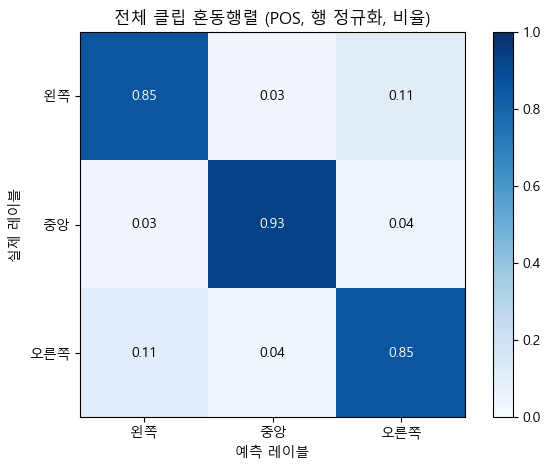


==== OVERALL (클립, UD) ====
Overall 클립 Acc: 0.837 | Balanced Acc: 0.837
              precision    recall  f1-score   support

          아래      0.835     0.847     0.841       411
           위      0.841     0.828     0.834       401

    accuracy                          0.837       812
   macro avg      0.838     0.837     0.837       812
weighted avg      0.837     0.837     0.837       812



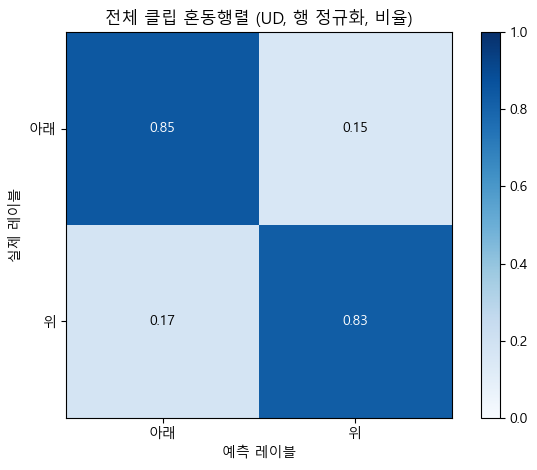

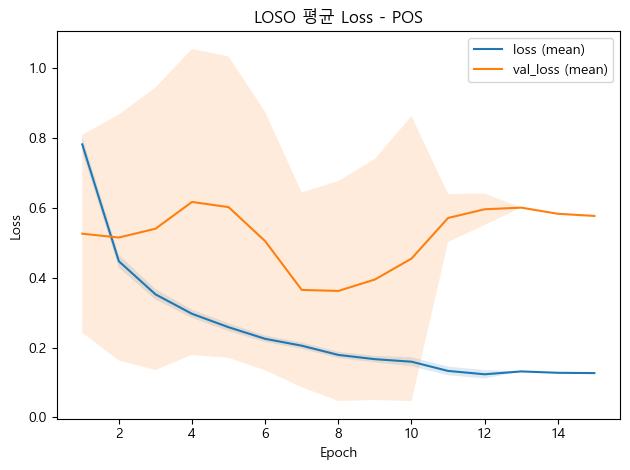

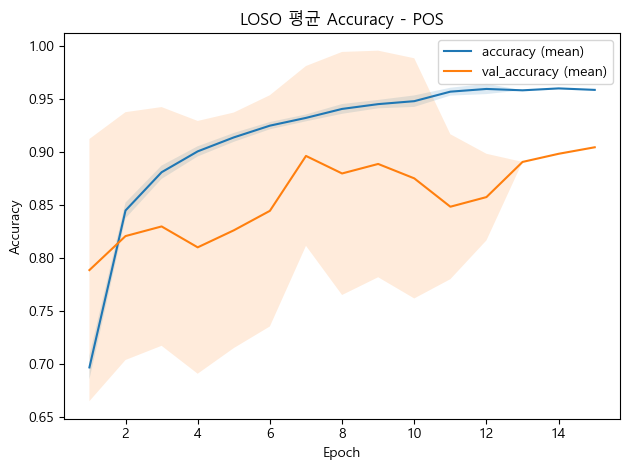

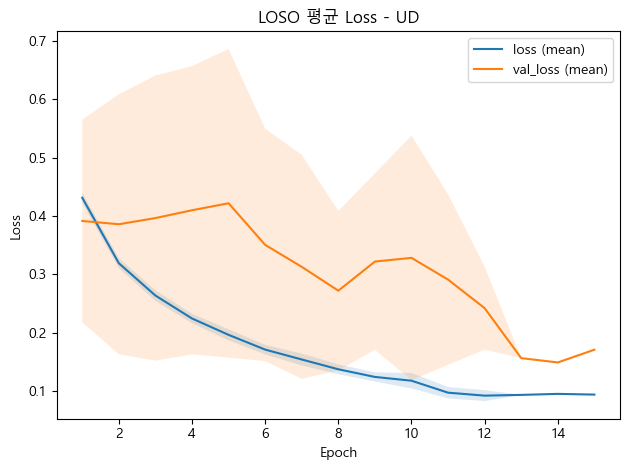

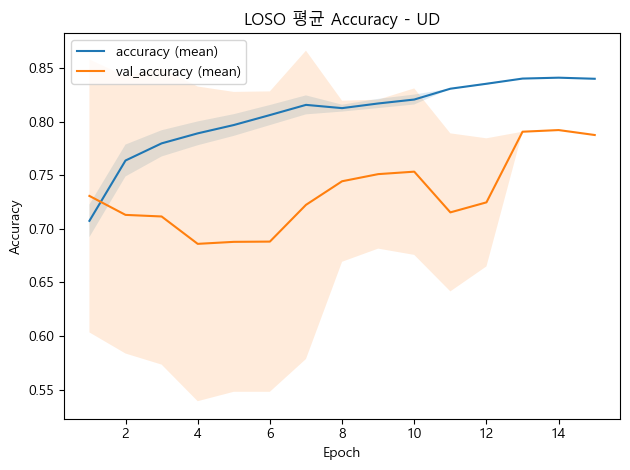

In [3]:
# === LOSO 멀티태스크 학습/평가 (pos + ud, class_weight 미사용: sample_weight로 통일) ===
import numpy as np, os, gc
from collections import defaultdict
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score

# === 과적합 지표 유틸 ===
def compute_overfit_indices(history_dict, head_name='pos'):
    """
    반환:
      gap_loss = val_loss - loss  (양수↑ = 과적합 경향)
      gap_acc  = train_acc - val_acc (양수↑ = 과적합 경향)
    """
    hd = history_dict
    gap = {'gap_loss': [], 'gap_acc': []}
    l_key, vl_key = f'{head_name}_loss', f'val_{head_name}_loss'
    a_key, va_key = f'{head_name}_accuracy', f'val_{head_name}_accuracy'
    L  = hd.get(l_key, [])
    VL = hd.get(vl_key, [])
    A  = hd.get(a_key, [])
    VA = hd.get(va_key, [])
    for i in range(min(len(L), len(VL))):
        gap['gap_loss'].append(VL[i] - L[i])
    for i in range(min(len(A), len(VA))):
        gap['gap_acc'].append(A[i] - VA[i])
    return gap

def simple_overfit_flag(history_dict, head='pos', th_gap_loss=0.20, th_gap_acc=0.10, last_k=3):
    """
    마지막 k 에포크 평균으로 간단 플래그.
    return: (flag, {'gap_loss':float, 'gap_acc':float})
    """
    gp = compute_overfit_indices(history_dict, head)
    if not gp['gap_loss'] or not gp['gap_acc']:
        return False, {'gap_loss': None, 'gap_acc': None}
    k = min(last_k, len(gp['gap_loss']), len(gp['gap_acc']))
    gl = float(np.mean(gp['gap_loss'][-k:]))
    ga = float(np.mean(gp['gap_acc'][-k:]))
    flag = (gl > th_gap_loss) and (ga > th_gap_acc)
    return flag, {'gap_loss': gl, 'gap_acc': ga}

# ----- 옵션 -----
EPOCHS = 40
BATCH_SIZE = 64
RLR_PATIENCE = 2
ES_PATIENCE  = 4           # EarlyStopping 추가

# ----- 준비 -----
persons = np.array([m["person"] for m in meta])
logo = LeaveOneGroupOut()
F = X.shape[-1]
HAND_DIMS = min(42, F)

histories = []
pos_win_accs, pos_clip_accs = [], []
ud_win_accs,  ud_clip_accs  = [], []
# 전체(모든 폴드) 클립 단위 예측/정답 누적
pos_clip_true_all, pos_clip_pred_all = [], []
ud_clip_true_all,  ud_clip_pred_all  = [], []

fold_no = 0
total_folds = len(np.unique(persons))

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1
    tf.keras.backend.clear_session(); gc.collect()

    # --- Split ---
    Xtr, Xva = X[train_idx], X[val_idx]
    y_pos_tr, y_pos_va = y_pos_all[train_idx], y_pos_all[val_idx]
    y_ud_tr,  y_ud_va  = y_ud_all_clipped[train_idx], y_ud_all_clipped[val_idx]
    sw_ud_tr, sw_ud_va = ud_valid_mask_all[train_idx], ud_valid_mask_all[val_idx]  # 1:유효, 0:NA

    # --- 스케일러 (train 활성 프레임 기반 fit → 전체 변환) ---
    scaler = fit_scaler_on_active(Xtr, F, hand_dims=HAND_DIMS, eps=1e-7)
    Xtr_s = scaler.transform(Xtr.reshape(-1, F)).reshape(Xtr.shape)
    Xva_s = scaler.transform(Xva.reshape(-1, F)).reshape(Xva.shape)

    # --- 클래스 불균형 보정: per-sample weight ---
    # POS
    pos_counts = np.bincount(y_pos_tr, minlength=3)
    pos_median = float(np.median(pos_counts[pos_counts > 0])) if (pos_counts > 0).any() else 1.0
    pos_weights_per_class = np.array([pos_median / max(c, 1) for c in pos_counts], dtype=np.float32)
    sw_pos_tr = np.ones(len(y_pos_tr), dtype=np.float32)
    for cls_idx, w in enumerate(pos_weights_per_class):
        sw_pos_tr[y_pos_tr == cls_idx] = w

    # UD (유효 샘플만 카운트)
    ud_tr_valid = y_ud_tr[sw_ud_tr.astype(bool)]
    if len(ud_tr_valid) > 0:
        ud_counts = np.bincount(ud_tr_valid, minlength=2)
        ud_median = float(np.median(ud_counts[ud_counts > 0])) if (ud_counts > 0).any() else 1.0
        ud_weights_per_class = np.array([ud_median / max(c, 1) for c in ud_counts], dtype=np.float32)
    else:
        ud_weights_per_class = np.array([1.0, 1.0], dtype=np.float32)

    sw_ud_tr_full = np.ones(len(y_ud_tr), dtype=np.float32)
    for cls_idx, w in enumerate(ud_weights_per_class):
        sw_ud_tr_full[y_ud_tr == cls_idx] = w
    sw_ud_tr_full *= sw_ud_tr.astype(np.float32)  # NA=0 마스킹

    # --- 모델 ---
    model = build_multitask_model(input_shape=(Xtr_s.shape[1], Xtr_s.shape[2]))

    # 콜백
    best_w_path = f'_tmp_mtl_best_fold{fold_no:02d}.weights.h5'
    cbs = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=best_w_path, monitor='val_loss',
                                           save_best_only=True, save_weights_only=True, verbose=0)
    ]

    # --- 학습 ---
    sw_valid = {
        'pos': np.ones(len(Xva_s), dtype=np.float32),
        'ud' : sw_ud_va.astype(np.float32)  # UD는 NA=0으로 마스킹
    }
    history = model.fit(
        Xtr_s,
        {'pos': y_pos_tr, 'ud': y_ud_tr},
        validation_data=(Xva_s, {'pos': y_pos_va, 'ud': y_ud_va}, sw_valid),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        sample_weight={'pos': sw_pos_tr, 'ud': sw_ud_tr_full},
        callbacks=cbs, verbose=1
    )

    # 베스트 가중치 보장
    if os.path.exists(best_w_path):
        model.load_weights(best_w_path)
        try: os.remove(best_w_path)
        except: pass

    histories.append(history.history)

    # --- 과적합 지표/경고 출력 ---
    flag_pos, gpos = simple_overfit_flag(history.history, head='pos', th_gap_loss=0.20, th_gap_acc=0.10, last_k=3)
    flag_ud,  gud  = simple_overfit_flag(history.history, head='ud',  th_gap_loss=0.20, th_gap_acc=0.10, last_k=3)
    print(f"[Fold {fold_no}] Overfit check - POS: flag={flag_pos}, last_k_gap={{loss:{gpos['gap_loss']:.3f}, acc:{gpos['gap_acc']:.3f}}}")
    print(f"[Fold {fold_no}] Overfit check -  UD: flag={flag_ud},  last_k_gap={{loss:{gud['gap_loss']:.3f}, acc:{gud['gap_acc']:.3f}}}")

    # --- 예측 ---
    p_pos_va, p_ud_va = model.predict(Xva_s, verbose=0)
    y_pos_pred = p_pos_va.argmax(1)
    y_ud_pred  = p_ud_va.argmax(1)

    # 윈도우 Acc
    pos_win_accs.append(accuracy_score(y_pos_va, y_pos_pred))
    if sw_ud_va.sum() > 0:
        mask = sw_ud_va.astype(bool)
        ud_win_accs.append(accuracy_score(y_ud_va[mask], y_ud_pred[mask]))

    # --- 클립 집계(확률 평균) ---
    val_meta = [meta[i] for i in val_idx]

    # POS
    bucket_pos, bucket_pos_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        bucket_pos[m["src"]].append(p_pos_va[i])
        bucket_pos_y[m["src"]] = y_pos_va[i]
    pos_P_clip, pos_Y_clip = [], []
    for src, ps in bucket_pos.items():
        pos_P_clip.append(np.mean(ps, axis=0))
        pos_Y_clip.append(bucket_pos_y[src])
    pos_clip_pred = np.argmax(np.vstack(pos_P_clip), axis=1)
    pos_clip_accs.append(accuracy_score(pos_Y_clip, pos_clip_pred))
    pos_clip_true_all.append(np.array(pos_Y_clip))
    pos_clip_pred_all.append(pos_clip_pred)

    # UD (유효 클립만)
    bucket_ud, bucket_ud_y = defaultdict(list), {}
    for i, m in enumerate(val_meta):
        if sw_ud_va[i] > 0.5:
            bucket_ud[m["src"]].append(p_ud_va[i])
            bucket_ud_y[m["src"]] = y_ud_va[i]
    if len(bucket_ud) > 0:
        ud_P_clip, ud_Y_clip = [], []
        for src, ps in bucket_ud.items():
            ud_P_clip.append(np.mean(ps, axis=0))
            ud_Y_clip.append(bucket_ud_y[src])
        ud_clip_pred = np.argmax(np.vstack(ud_P_clip), axis=1)
        ud_clip_accs.append(accuracy_score(ud_Y_clip, ud_clip_pred))
        ud_clip_true_all.append(np.array(ud_Y_clip))
        ud_clip_pred_all.append(ud_clip_pred)

# ===== 집계 출력 =====
pos_clip_true_all = np.concatenate(pos_clip_true_all, axis=0) if len(pos_clip_true_all)>0 else np.array([])
pos_clip_pred_all = np.concatenate(pos_clip_pred_all, axis=0) if len(pos_clip_pred_all)>0 else np.array([])
ud_clip_true_all  = np.concatenate(ud_clip_true_all, axis=0)  if len(ud_clip_true_all)>0  else np.array([])
ud_clip_pred_all  = np.concatenate(ud_clip_pred_all, axis=0)  if len(ud_clip_pred_all)>0  else np.array([])

print("\n==== POS(왼/중/오) ====")
print(f"Win Acc:  {np.mean(pos_win_accs):.3f} ± {np.std(pos_win_accs):.3f}")
print(f"Clip Acc: {np.mean(pos_clip_accs):.3f} ± {np.std(pos_clip_accs):.3f}")

if len(ud_win_accs) > 0:
    print("\n==== UD(아래/위, 유효 샘플만) ====")
    print(f"Win Acc:  {np.mean(ud_win_accs):.3f} ± {np.std(ud_win_accs):.3f}")
if len(ud_clip_accs) > 0:
    print(f"Clip Acc: {np.mean(ud_clip_accs):.3f} ± {np.std(ud_clip_accs):.3f}")

# ---- 헤드별 Overall(클립) 리포트 & 혼동행렬 ----
if pos_clip_true_all.size > 0:
    pos_overall_acc = accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    pos_bal_acc     = balanced_accuracy_score(pos_clip_true_all, pos_clip_pred_all)
    print("\n==== OVERALL (클립, POS) ====")
    print(f"Overall 클립 Acc: {pos_overall_acc:.3f} | Balanced Acc: {pos_bal_acc:.3f}")
    print(classification_report(pos_clip_true_all, pos_clip_pred_all, target_names=POS_NAMES, digits=3))
    cm_pos = confusion_matrix(pos_clip_true_all, pos_clip_pred_all, labels=[0,1,2])
    plot_confmat_ratio(cm_pos, POS_NAMES, '전체 클립 혼동행렬 (POS, 행 정규화, 비율)')

if ud_clip_true_all.size > 0:
    ud_overall_acc = accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    ud_bal_acc     = balanced_accuracy_score(ud_clip_true_all, ud_clip_pred_all)
    print("\n==== OVERALL (클립, UD) ====")
    print(f"Overall 클립 Acc: {ud_overall_acc:.3f} | Balanced Acc: {ud_bal_acc:.3f}")
    print(classification_report(ud_clip_true_all, ud_clip_pred_all, target_names=UD_NAMES, digits=3))
    cm_ud = confusion_matrix(ud_clip_true_all, ud_clip_pred_all, labels=[0,1])
    plot_confmat_ratio(cm_ud, UD_NAMES, '전체 클립 혼동행렬 (UD, 행 정규화, 비율)')

# ---- 헤드별 LOSO 평균 곡선 ----
plot_mean_training_curves_head(histories, head_name='pos')
plot_mean_training_curves_head(histories, head_name='ud')

In [12]:
# === 기본 설정 & 임포트 ===
import os, glob, json, math, random, gc
import numpy as np
from collections import defaultdict
from statistics import mean

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ★ 사용자 설정
PROJECT_TAG   = "v3"  # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()  # 노트북 위치 기준
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일; 13-class)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN = 30      # 2초 창 (15fps * 2s)
STRIDE  = 5
MIN_ACTIVE_RATIO   = 0.20 # 창 내 손-검출 프레임 비율 하한
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계

# === 윈도잉 & 마스크 유틸 ===
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)
    return (e > eps).astype(np.float32)[:, None]

def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F) -> [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    손 좌표(앞 hand_dims)를 프레임별로 검사하여 non-zero 프레임 비율 반환
    """
    H = min(hand_dims, win.shape[1])
    fr = win[:, :H]
    nz = (np.abs(fr).sum(axis=1) > eps)
    return nz.mean()

# === 매니페스트 스캔 ===
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir):
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir):
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            if arr.ndim != 2:
                print(f"[warn] skip non-2D: {npy}, shape={arr.shape}")
                continue
            T, F = arr.shape
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

print("총 manifest:", len(manifest))
if len(manifest) == 0:
    raise RuntimeError("manifest가 비었습니다. 데이터 경로/구조를 확인하세요.")

# === 데이터 전역 통계 ===
feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)

# === 윈도 생성 및 필터링 ===
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    if arr.ndim != 2 or arr.shape[1] != FEAT_DIM:
        print(f"[warn] Skip due to wrong dim: {m['path']}, shape={arr.shape}")
        continue

    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue

    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                             # (L, F)
            M.append(frame_active_mask(w))          # (L, 1)  - (옵션) 현재 미사용
            y.append(m["y"])                        # 13-class
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)
y = np.array(y)           # (N,)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)

# === 13→태스크 라벨 매핑 (pos=왼/중/오, ud=아래/위/NA) ===
import numpy as np

POS_NAMES = ['왼쪽','중앙','오른쪽']   # head #1
UD_NAMES  = ['아래','위']            # head #2 (씹는면/설·구개는 규칙으로 투영)

labels_np = np.array(KOREAN_LABELS, dtype=object)

def _pos_from_label(lab: str) -> int:
    if lab.startswith('왼쪽'):   return 0
    if lab.startswith('중앙'):   return 1
    if lab.startswith('오른쪽'): return 2
    raise ValueError(f"Unexpected label for pos: {lab}")

def _ud_from_label(lab: str) -> int:
    # 씹는면
    if '씹는면' in lab:
        return 1 if '위' in lab else 0
    # 구개측은 위쪽
    if '구개측' in lab:
        return 1
    # 설측은 아래쪽
    if '설측' in lab:
        return 0
    # 협측은 NA
    return -1

# 전체 샘플에 대해 태스크 라벨 생성
y_pos_all = np.array([_pos_from_label(labels_np[i]) for i in y], dtype=np.int64)
y_ud_all  = np.array([_ud_from_label(labels_np[i])  for i in y], dtype=np.int64)

# ud 유효/무효 마스크 (1:유효, 0:무효)
ud_valid_mask_all = (y_ud_all != -1).astype(np.float32)

# Keras는 -1 라벨 불가 → 더미 0으로 대체하고, 손실은 sample_weight로 마스킹
y_ud_all_clipped = np.where(y_ud_all == -1, 0, y_ud_all)

# === 스케일러 fit 유틸 (활성 프레임만) ===
from sklearn.preprocessing import StandardScaler

def fit_scaler_on_active(X_train, F, hand_dims=42, eps=1e-7):
    Xtr_flat = X_train.reshape(-1, F)
    H = min(hand_dims, F)
    mask = (np.abs(Xtr_flat[:, :H]).sum(axis=1) > eps)
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
    return scaler

# === 플롯 유틸 ===
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False
setup_korean_font()

# --- 공통: NaN 패딩 평균/표준편차 ---
def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

# --- 단일 폴드 디버그용(옵션) ---
def plot_training_curves(history, fold_no, head_name=None):
    H = history.history if hasattr(history, "history") else history
    if head_name is None:
        plt.figure()
        plt.plot(H.get('loss', []), label='loss')
        plt.plot(H.get('val_loss', []), label='val_loss')
        plt.title(f'Fold {fold_no} - Total Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
    else:
        lkey, vlkey = f'{head_name}_loss', f'val_{head_name}_loss'
        akey, vakey = f'{head_name}_accuracy', f'val_{head_name}_accuracy'
        if lkey in H and vlkey in H:
            plt.figure()
            plt.plot(H[lkey],  label=lkey)
            plt.plot(H[vlkey], label=vlkey)
            plt.title(f'Fold {fold_no} - Loss ({head_name.upper()})'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
        if akey in H and vakey in H:
            plt.figure()
            plt.plot(H[akey],  label=akey)
            plt.plot(H[vakey], label=vakey)
            plt.title(f'Fold {fold_no} - Acc ({head_name.upper()})'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

# --- LOSO 평균 곡선(헤드별) ---
def plot_mean_training_curves_head(histories, head_name='pos', title_prefix='LOSO 평균'):
    # 수집
    loss_list      = [h.get(f'{head_name}_loss', [])      for h in histories]
    val_loss_list  = [h.get(f'val_{head_name}_loss', [])  for h in histories]
    acc_list       = [h.get(f'{head_name}_accuracy', [])  for h in histories]
    val_acc_list   = [h.get(f'val_{head_name}_accuracy', []) for h in histories]

    # 평균/표준편차 (NaN 무시)
    mean_loss, std_loss           = _nanmean_along_epochs(loss_list)
    mean_val_loss, std_val_loss   = _nanmean_along_epochs(val_loss_list)
    mean_acc, std_acc             = _nanmean_along_epochs(acc_list)       if acc_list  else (None, None)
    mean_val_acc, std_val_acc     = _nanmean_along_epochs(val_acc_list)   if val_acc_list else (None, None)

    # Loss
    if mean_loss is not None and mean_val_loss is not None:
        x = np.arange(1, len(mean_loss)+1)
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        if std_loss is not None:
            plt.fill_between(x, mean_loss - std_loss,       mean_loss + std_loss,       alpha=0.15)
        if std_val_loss is not None:
            plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title(f'{title_prefix} Loss - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    if mean_acc is not None and mean_val_acc is not None:
        x = np.arange(1, len(mean_acc)+1)
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        if std_acc is not None:
            plt.fill_between(x, mean_acc - std_acc,       mean_acc + std_acc,       alpha=0.15)
        if std_val_acc is not None:
            plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title(f'{title_prefix} Accuracy - {head_name.upper()}')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블'); plt.xlabel('예측 레이블'  )
    plt.tight_layout(); plt.show()


총 manifest: 654
Feature dims found: [48]
Clips: 654, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 48
Windows kept: 16347, dropped_short: 0, dropped_inactive: 0
X shape: (16347, 30, 48) M shape: (16347, 30, 1) y shape: (16347,)


In [13]:
import numpy as np

CLASS_NAMES = ['왼쪽','중앙','오른쪽']

labels_np = np.array(KOREAN_LABELS, dtype=object)
lab_to_group = {
    l: ('왼쪽' if l.startswith('왼쪽') else
        '중앙' if l.startswith('중앙') else
        '오른쪽')
    for l in labels_np
}
group_to_idx = {'왼쪽':0, '중앙':1, '오른쪽':2}

def map_y_to_3(y13):
    return np.array([group_to_idx[lab_to_group[labels_np[i]]] for i in y13])


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_curves(history, fold_no, model_name):
    H = history.history
    # Loss
    plt.figure()
    plt.plot(H.get('loss', []),     label='loss')
    plt.plot(H.get('val_loss', []), label='val_loss')
    plt.title(f'[{model_name}] Fold {fold_no} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    if 'accuracy' in H and 'val_accuracy' in H:
        plt.figure()
        plt.plot(H['accuracy'],     label='accuracy')
        plt.plot(H['val_accuracy'], label='val_accuracy')
        plt.title(f'[{model_name}] Fold {fold_no} - Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

def _nanmean_along_epochs(list_of_lists):
    if not list_of_lists:
        return None, None
    maxlen = max(len(s) for s in list_of_lists)
    M = np.full((len(list_of_lists), maxlen), np.nan, dtype=np.float32)
    for i, s in enumerate(list_of_lists):
        arr = np.asarray(s, dtype=np.float32)
        M[i, :len(arr)] = arr
    return np.nanmean(M, axis=0), np.nanstd(M, axis=0)

def plot_mean_training_curves(histories, model_name):
    # Loss
    mean_loss, std_loss         = _nanmean_along_epochs([h['loss'] for h in histories])
    mean_val_loss, std_val_loss = _nanmean_along_epochs([h['val_loss'] for h in histories])
    if mean_loss is not None:
        x = np.arange(len(mean_loss))
        plt.figure()
        plt.plot(x, mean_loss,     label='loss (mean)')
        plt.plot(x, mean_val_loss, label='val_loss (mean)')
        plt.fill_between(x, mean_loss - std_loss, mean_loss + std_loss, alpha=0.15)
        plt.fill_between(x, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.15)
        plt.title(f'[{model_name}] LOSO 평균 Loss (Epoch)')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    has_acc = all(('accuracy' in h and 'val_accuracy' in h) for h in histories)
    if has_acc:
        mean_acc, std_acc         = _nanmean_along_epochs([h['accuracy'] for h in histories])
        mean_val_acc, std_val_acc = _nanmean_along_epochs([h['val_accuracy'] for h in histories])
        x = np.arange(len(mean_acc))
        plt.figure()
        plt.plot(x, mean_acc,     label='accuracy (mean)')
        plt.plot(x, mean_val_acc, label='val_accuracy (mean)')
        plt.fill_between(x, mean_acc - std_acc, mean_acc + std_acc, alpha=0.15)
        plt.fill_between(x, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.15)
        plt.title(f'[{model_name}] LOSO 평균 Accuracy (Epoch)')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy')
        plt.legend(); plt.tight_layout(); plt.show()

def norm_cm(cm):
    with np.errstate(invalid='ignore', divide='ignore'):
        cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cmn = np.nan_to_num(cmn)
    return cmn

def plot_confmat_ratio(cm, classes, title):
    M = norm_cm(cm)
    plt.figure()
    im = plt.imshow(M, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar(im)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = M[i, j]
            txt_color = 'black' if val < 0.6 else 'white'
            plt.text(j, i, f"{val:.2f}", ha="center", va="center", color=txt_color, fontsize=10)
    plt.ylabel('실제 레이블')
    plt.xlabel('예측 레이블')
    plt.tight_layout()
    plt.show()


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

def _compile(model):
    opt  = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model

def build_gru_model(input_shape, n_classes=3):
    inp = layers.Input(shape=input_shape)               # (SEQ_LEN, FEAT_DIM)
    x = layers.GaussianNoise(0.01)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.GRU(
        96, return_sequences=True,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.GRU(
        64, return_sequences=False,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(3, activation="softmax")(x)
    model = tf.keras.Model(inp, out)
    return _compile(model)

def build_lstm_model(input_shape, n_classes=3):
    inp = layers.Input(shape=input_shape)               # (SEQ_LEN, FEAT_DIM)
    x = layers.GaussianNoise(0.01)(inp)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.LSTM(
        96, return_sequences=True,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.LSTM(
        64, return_sequences=False,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(3, activation="softmax")(x)
    model = tf.keras.Model(inp, out)
    return _compile(model)

# 요약 & 파라미터 확인
tmp_gru = build_gru_model((SEQ_LEN, FEAT_DIM), n_classes=3)
tmp_lstm = build_lstm_model((SEQ_LEN, FEAT_DIM), n_classes=3)
tmp_gru.summary(line_length=120, expand_nested=False, show_trainable=True)
print("gru params:", tmp_gru.count_params())
print("lstm params:", tmp_lstm.count_params())


Model: "model_23"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 input_24 (InputLayer)                                [(None, 30, 48)]                                0                 Y          
                                                                                                                                   
 gaussian_noise_23 (GaussianNoise)                    (None, 30, 48)                                  0                 Y          
                                                                                                                                   
 spatial_dropout1d_23 (SpatialDropout1D)              (None, 30, 48)                                  0                 Y          
                                                          

In [16]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from collections import defaultdict
import numpy as np
import tensorflow as tf

def run_loso_experiment(model_name: str, build_fn):
    print(f"\n================= [{model_name.upper()}] 실험 시작 =================")
    F = X.shape[-1]
    HAND_DIMS = 42 if F >= 42 else F
    EPS = 1e-7
    logo = LeaveOneGroupOut()
    persons = np.array([m["person"] for m in meta])

    histories = []
    all_win_true, all_win_pred = [], []
    all_clip_true, all_clip_pred = [], []
    all_win_acc, all_clip_acc = [], []

    total_folds = len(np.unique(persons))
    fold_no = 0

    # 모델 파라미터 수(입력 shape로 생성하여 카운트)
    param_count = build_fn((SEQ_LEN, F), n_classes=3).count_params()
    print(f"[{model_name}] params: {param_count}")

    for train_idx, val_idx in logo.split(X, y, groups=persons):
        fold_no += 1
        # Split
        X_train, y_train = X[train_idx], y[train_idx]
        X_val,   y_val   = X[val_idx],   y[val_idx]
        y_train_3 = map_y_to_3(y_train)
        y_val_3   = map_y_to_3(y_val)

        # 스케일러 (train만 fit, 제로 프레임 제외)
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr_flat = X_train.reshape(-1, F)
        mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
        scaler.fit(Xtr_flat[mask] if mask.any() else Xtr_flat)
        X_train_s = scaler.transform(Xtr_flat).reshape(X_train.shape)
        X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

        # 모델 생성
        model = build_fn((X_train_s.shape[1], X_train_s.shape[2]), n_classes=3)

        # 클래스 불균형 가중치
        cls_counts = np.bincount(y_train_3, minlength=3)
        class_weights = {i: float(np.median(cls_counts)/c) for i,c in enumerate(cls_counts)}

        # 콜백
        cb = [
            tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5),
        ]

        # 학습
        history = model.fit(
            X_train_s, y_train_3,
            validation_data=(X_val_s, y_val_3),
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            class_weight=class_weights,
            callbacks=cb, verbose=1
        )
        histories.append(history.history)

        # (옵션) 마지막 폴드만 개별 곡선 표시
        if PLOT_LAST_FOLD_CURVES and fold_no == total_folds:
            plot_training_curves(history, fold_no, model_name)

        # 윈도우 예측/평가
        p3 = model.predict(X_val_s, verbose=0)
        y_pred = p3.argmax(1)
        win_acc = accuracy_score(y_val_3, y_pred)
        all_win_acc.append(win_acc)
        all_win_true.append(y_val_3); all_win_pred.append(y_pred)

        # 클립 집계
        bucket_p, bucket_y = defaultdict(list), {}
        val_meta = [meta[i] for i in val_idx]
        for i, m_ in enumerate(val_meta):
            bucket_p[m_["src"]].append(p3[i])
            bucket_y[m_["src"]] = y_val_3[i]
        P_clip, Y_clip = [], []
        for src, ps in bucket_p.items():
            P_clip.append(np.mean(ps, axis=0))
            Y_clip.append(bucket_y[src])
        clip_pred = np.argmax(np.vstack(P_clip), axis=1)
        clip_acc = accuracy_score(Y_clip, clip_pred)
        all_clip_acc.append(clip_acc)
        all_clip_true.append(np.array(Y_clip))
        all_clip_pred.append(clip_pred)

        print(f"[{model_name.upper()}][Fold {fold_no}/{total_folds}] "
              f"win_acc={win_acc:.3f}, clip_acc={clip_acc:.3f}")

    # 폴드 전체 결합
    all_win_true  = np.concatenate(all_win_true, axis=0)
    all_win_pred  = np.concatenate(all_win_pred, axis=0)
    all_clip_true = np.concatenate(all_clip_true, axis=0)
    all_clip_pred = np.concatenate(all_clip_pred, axis=0)

    mean_win = float(np.mean(all_win_acc)); std_win = float(np.std(all_win_acc))
    mean_clip = float(np.mean(all_clip_acc)); std_clip = float(np.std(all_clip_acc))

    # 최종 레벨 선택
    if EVAL_LEVEL == "clip":
        y_true_overall = all_clip_true
        y_pred_overall = all_clip_pred
        level_name = "클립"
    else:
        y_true_overall = all_win_true
        y_pred_overall = all_win_pred
        level_name = "윈도우"

    # 지표: Acc / F1 (micro=accuracy와 동일) / Macro-F1
    overall_acc = accuracy_score(y_true_overall, y_pred_overall)
    overall_f1_micro = f1_score(y_true_overall, y_pred_overall, average="micro")
    overall_f1_macro = f1_score(y_true_overall, y_pred_overall, average="macro")

    print(f"\n==== [{model_name.upper()}] LOSO Summary ====")
    print(f"Mean Window Acc: {mean_win:.3f} ± {std_win:.3f}")
    print(f"Mean Clip   Acc: {mean_clip:.3f} ± {std_clip:.3f}")
    print(f"OVERALL {level_name} Acc: {overall_acc:.3f}")
    print(f"OVERALL {level_name} F1 (micro): {overall_f1_micro:.3f}")
    print(f"OVERALL {level_name} F1 (macro): {overall_f1_macro:.3f}")
    print("\n-- Classification Report --")
    print(classification_report(y_true_overall, y_pred_overall, target_names=CLASS_NAMES, digits=3))

    # 혼동행렬 + 평균 곡선
    cm_overall = confusion_matrix(y_true_overall, y_pred_overall, labels=[0,1,2])
    plot_confmat_ratio(cm_overall, CLASS_NAMES, f'[{model_name.upper()}] 전체 {level_name} 혼동행렬 (행 정규화, 비율)')
    plot_mean_training_curves(histories, model_name)

    # 결과 반환(요약 표용)
    return {
        "model": model_name,
        "params": int(param_count),
        "mean_win_acc": float(mean_win), "std_win_acc": float(std_win),
        "mean_clip_acc": float(mean_clip), "std_clip_acc": float(std_clip),
        "overall_level": level_name,
        "overall_acc": float(overall_acc),
        "overall_f1_micro": float(overall_f1_micro),
        "overall_f1_macro": float(overall_f1_macro),
    }



================= [GRU] 실험 시작 =================
[gru] params: 77763
Epoch 1/80
231/231 [==============================] - 4s 9ms/step - loss: 1.0280 - accuracy: 0.6284 - val_loss: 0.6060 - val_accuracy: 0.7385 - lr: 3.0000e-04
Epoch 2/80
231/231 [==============================] - 2s 7ms/step - loss: 0.6713 - accuracy: 0.7669 - val_loss: 0.3401 - val_accuracy: 0.8825 - lr: 3.0000e-04
Epoch 3/80
231/231 [==============================] - 2s 7ms/step - loss: 0.5643 - accuracy: 0.8137 - val_loss: 0.2230 - val_accuracy: 0.9218 - lr: 3.0000e-04
Epoch 4/80
231/231 [==============================] - 2s 7ms/step - loss: 0.5081 - accuracy: 0.8368 - val_loss: 0.2219 - val_accuracy: 0.9243 - lr: 3.0000e-04
Epoch 5/80
231/231 [==============================] - 2s 7ms/step - loss: 0.4530 - accuracy: 0.8567 - val_loss: 0.2883 - val_accuracy: 0.8942 - lr: 3.0000e-04
Epoch 6/80
231/231 [==============================] - 2s 7ms/step - loss: 0.4258 - accuracy: 0.8654 - val_loss: 0.4957 - val_accuracy: 0

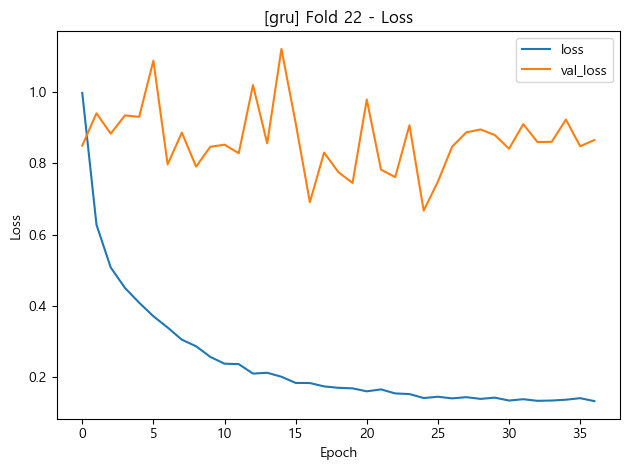

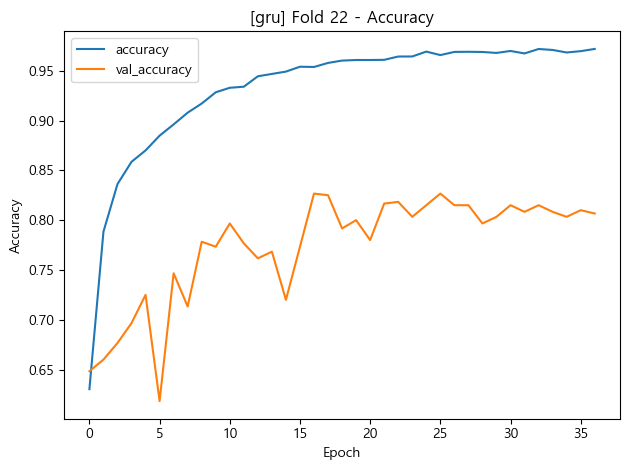

[GRU][Fold 22/22] win_acc=0.815, clip_acc=0.833

==== [GRU] LOSO Summary ====
Mean Window Acc: 0.828 ± 0.113
Mean Clip   Acc: 0.839 ± 0.117
OVERALL 클립 Acc: 0.855
OVERALL 클립 F1 (micro): 0.855
OVERALL 클립 F1 (macro): 0.859

-- Classification Report --
              precision    recall  f1-score   support

          왼쪽      0.862     0.831     0.846       255
          중앙      0.881     0.887     0.884       150
         오른쪽      0.833     0.859     0.846       249

    accuracy                          0.855       654
   macro avg      0.858     0.859     0.859       654
weighted avg      0.855     0.855     0.855       654



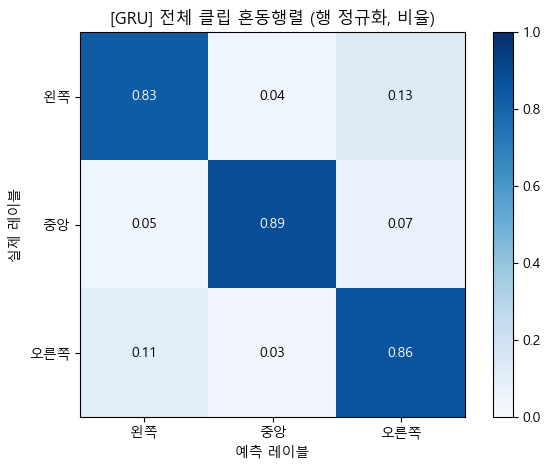

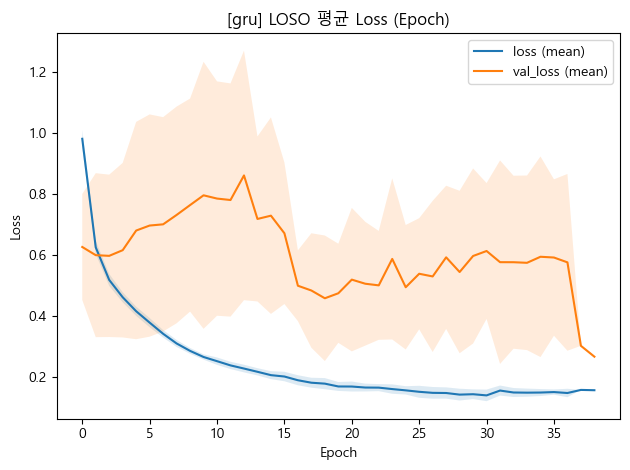

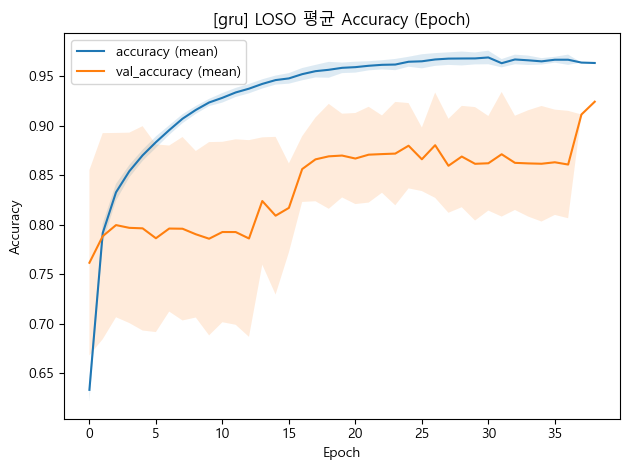


================= [LSTM] 실험 시작 =================
[lstm] params: 101507
Epoch 1/80
231/231 [==============================] - 5s 13ms/step - loss: 0.8008 - accuracy: 0.7074 - val_loss: 0.5526 - val_accuracy: 0.8123 - lr: 3.0000e-04
Epoch 2/80
231/231 [==============================] - 2s 9ms/step - loss: 0.4822 - accuracy: 0.8450 - val_loss: 0.5731 - val_accuracy: 0.7668 - lr: 3.0000e-04
Epoch 3/80
231/231 [==============================] - 2s 10ms/step - loss: 0.3950 - accuracy: 0.8749 - val_loss: 0.7840 - val_accuracy: 0.8418 - lr: 3.0000e-04
Epoch 4/80
231/231 [==============================] - 2s 9ms/step - loss: 0.3440 - accuracy: 0.8959 - val_loss: 0.8039 - val_accuracy: 0.7877 - lr: 3.0000e-04
Epoch 5/80
231/231 [==============================] - 2s 10ms/step - loss: 0.3039 - accuracy: 0.9081 - val_loss: 1.0252 - val_accuracy: 0.7415 - lr: 3.0000e-04
Epoch 6/80
231/231 [==============================] - 2s 9ms/step - loss: 0.2797 - accuracy: 0.9180 - val_loss: 0.8910 - val_accur

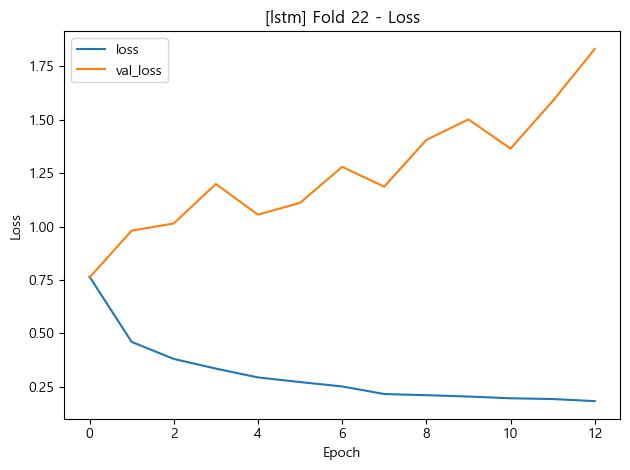

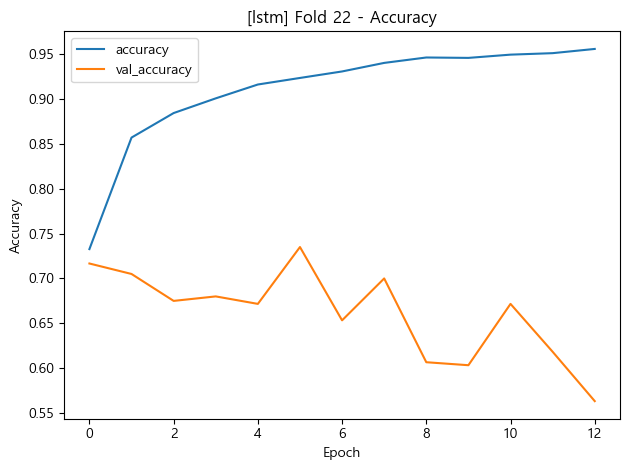

[LSTM][Fold 22/22] win_acc=0.717, clip_acc=0.708

==== [LSTM] LOSO Summary ====
Mean Window Acc: 0.805 ± 0.102
Mean Clip   Acc: 0.814 ± 0.116
OVERALL 클립 Acc: 0.829
OVERALL 클립 F1 (micro): 0.829
OVERALL 클립 F1 (macro): 0.836

-- Classification Report --
              precision    recall  f1-score   support

          왼쪽      0.831     0.827     0.829       255
          중앙      0.881     0.887     0.884       150
         오른쪽      0.795     0.795     0.795       249

    accuracy                          0.829       654
   macro avg      0.836     0.836     0.836       654
weighted avg      0.829     0.829     0.829       654



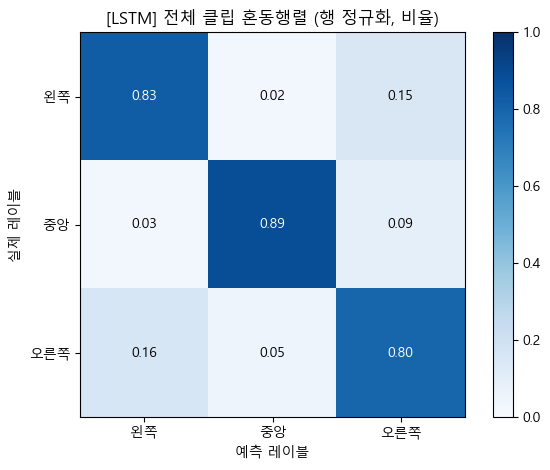

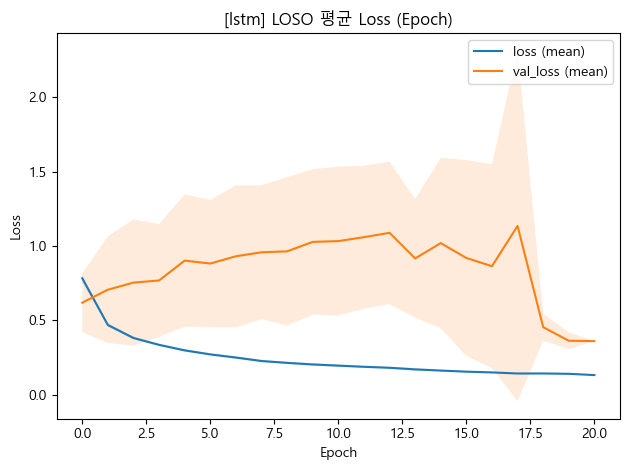

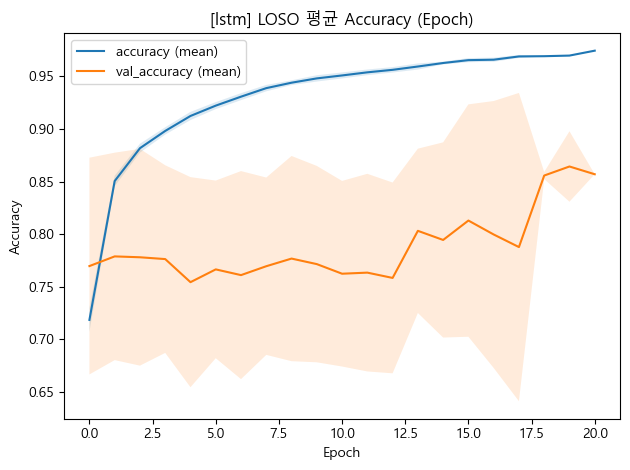


===== 모델 비교 요약 =====
model  params  mean_win_acc  std_win_acc  mean_clip_acc  std_clip_acc overall_level  overall_acc  overall_f1_micro  overall_f1_macro
  gru   77763      0.827935     0.113490       0.838597      0.116602            클립     0.854740          0.854740          0.858626
 lstm  101507      0.805256     0.101697       0.814159      0.115738            클립     0.828746          0.828746          0.835993


In [19]:
import pandas as pd


PLOT_LAST_FOLD_CURVES = True
EVAL_LEVEL = "clip" 

results = []
results.append(run_loso_experiment("gru",  build_gru_model))
results.append(run_loso_experiment("lstm", build_lstm_model))

df = pd.DataFrame(results, columns=[
    "model","params",
    "mean_win_acc","std_win_acc","mean_clip_acc","std_clip_acc",
    "overall_level","overall_acc","overall_f1_micro","overall_f1_macro"
])

print("\n===== 모델 비교 요약 =====")
print(df.to_string(index=False))
